In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Documents/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2025/RADIOLOGIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 11 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=147.0, y1=102.2
Page 1, Q1, A: Yellow pixels: 1127
Page 1, Q1, A: Total non-white pixels: 1419
Page 1, Q1, A: Yellow percentage: 79.4%


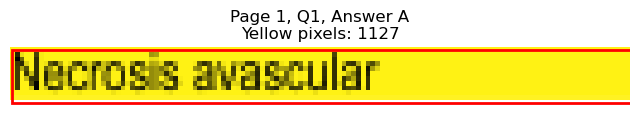

Page 1, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=106.9, y1=114.8
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 172
Page 1, Q1, B: Yellow percentage: 0.0%


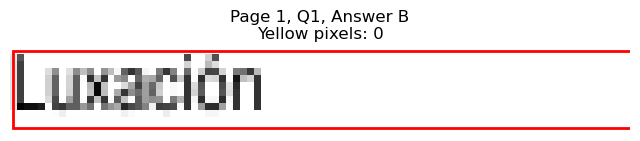

Page 1, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=436.8, y1=102.2
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 542
Page 1, Q1, C: Yellow percentage: 0.0%


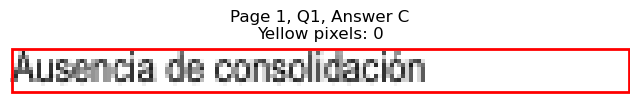

Page 1, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=412.2, y1=114.8
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 439
Page 1, Q1, D: Yellow percentage: 0.0%


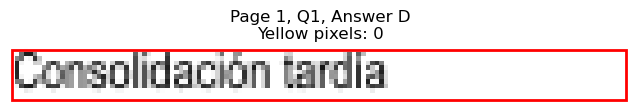


Page 1, Q1 - Selected Answer: A (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=154.3, x1=173.6, y1=165.3
Page 1, Q2, A: Yellow pixels: 156
Page 1, Q2, A: Total non-white pixels: 764
Page 1, Q2, A: Yellow percentage: 20.4%


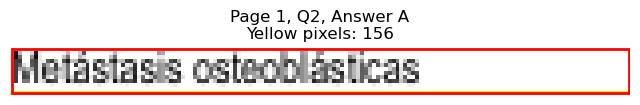

Page 1, Q2 - B: Detected box: x0=68.3, y0=166.9, x1=122.4, y1=177.9
Page 1, Q2, B: Yellow pixels: 1021
Page 1, Q2, B: Total non-white pixels: 1260
Page 1, Q2, B: Yellow percentage: 81.0%


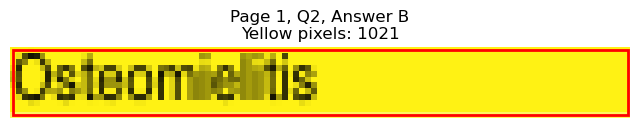

Page 1, Q2 - C: Detected box: x0=327.5, y0=154.3, x1=407.9, y1=165.3
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 407
Page 1, Q2, C: Yellow percentage: 0.0%


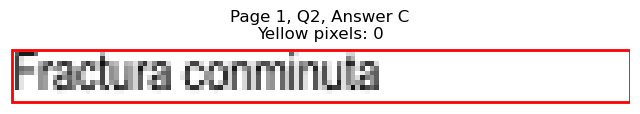

Page 1, Q2 - D: Detected box: x0=327.5, y0=166.9, x1=383.2, y1=177.9
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 285
Page 1, Q2, D: Yellow percentage: 0.0%


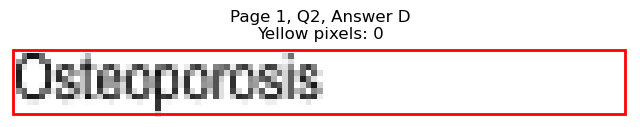


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=217.4, x1=81.4, y1=228.4
Page 1, Q3, A: Yellow pixels: 664
Page 1, Q3, A: Total non-white pixels: 768
Page 1, Q3, A: Yellow percentage: 86.5%


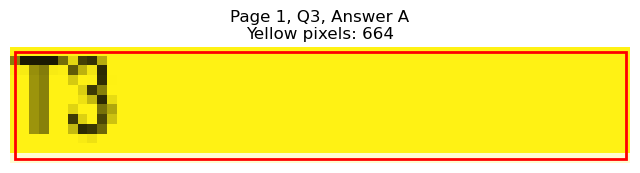

Page 1, Q3 - B: Detected box: x0=68.3, y0=230.0, x1=81.4, y1=241.0
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 51
Page 1, Q3, B: Yellow percentage: 0.0%


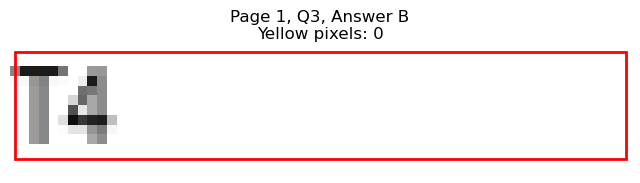

Page 1, Q3 - C: Detected box: x0=327.5, y0=217.4, x1=340.6, y1=228.4
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 42
Page 1, Q3, C: Yellow percentage: 0.0%


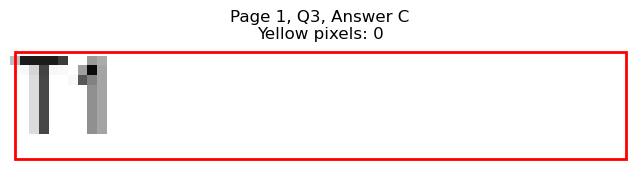

Page 1, Q3 - D: Detected box: x0=327.5, y0=230.0, x1=340.6, y1=241.0
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 50
Page 1, Q3, D: Yellow percentage: 0.0%


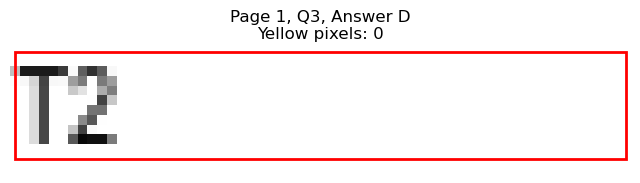


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=267.8, x1=120.0, y1=278.8
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 282
Page 1, Q4, A: Yellow percentage: 0.0%


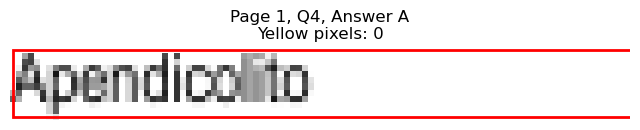

Page 1, Q4 - B: Detected box: x0=68.3, y0=280.5, x1=230.8, y1=291.6
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 826
Page 1, Q4, B: Yellow percentage: 0.0%


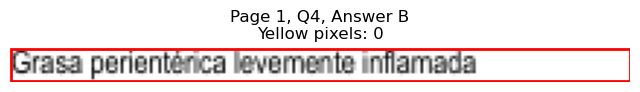

Page 1, Q4 - C: Detected box: x0=327.5, y0=267.8, x1=431.3, y1=278.8
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 670
Page 1, Q4, C: Yellow percentage: 0.0%


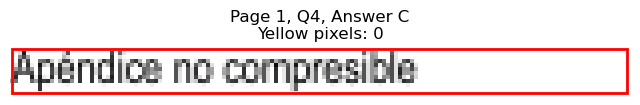

Page 1, Q4 - D: Detected box: x0=327.5, y0=280.5, x1=434.3, y1=291.6
Page 1, Q4, D: Yellow pixels: 1315
Page 1, Q4, D: Total non-white pixels: 1896
Page 1, Q4, D: Yellow percentage: 69.4%


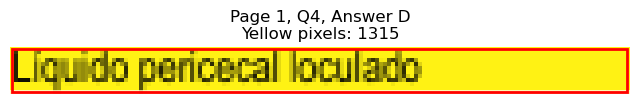


Page 1, Q4 - Selected Answer: D (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=330.9, x1=102.8, y1=342.0
Page 1, Q5, A: Yellow pixels: 909
Page 1, Q5, A: Total non-white pixels: 1020
Page 1, Q5, A: Yellow percentage: 89.1%


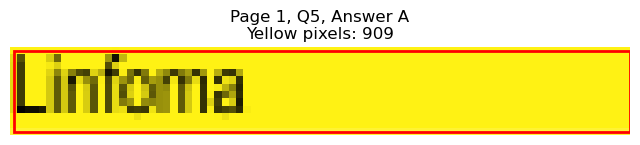

Page 1, Q5 - B: Detected box: x0=68.3, y0=343.6, x1=138.0, y1=354.7
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 352
Page 1, Q5, B: Yellow percentage: 0.0%


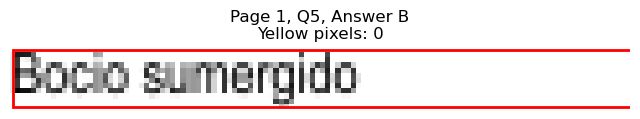

Page 1, Q5 - C: Detected box: x0=327.5, y0=330.9, x1=368.6, y1=342.0
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 204
Page 1, Q5, C: Yellow percentage: 0.0%


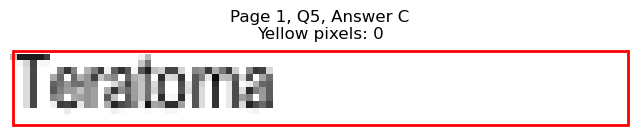

Page 1, Q5 - D: Detected box: x0=327.5, y0=343.6, x1=362.6, y1=354.7
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 164
Page 1, Q5, D: Yellow percentage: 0.0%


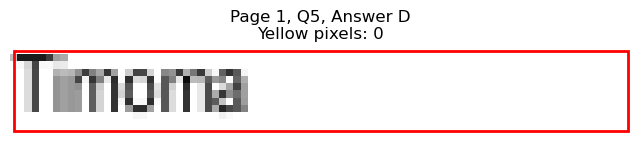


Page 1, Q5 - Selected Answer: A (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=406.6, x1=167.0, y1=417.7
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 511
Page 1, Q6, A: Yellow percentage: 0.0%


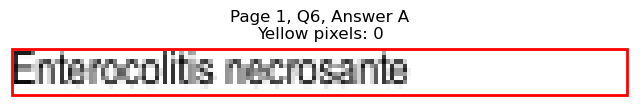

Page 1, Q6 - B: Detected box: x0=68.3, y0=419.4, x1=203.2, y1=430.4
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 687
Page 1, Q6, B: Yellow percentage: 0.0%


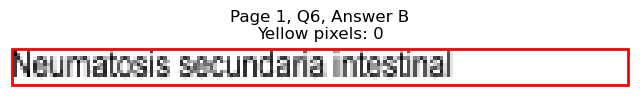

Page 1, Q6 - C: Detected box: x0=327.5, y0=406.6, x1=460.3, y1=417.7
Page 1, Q6, C: Yellow pixels: 184
Page 1, Q6, C: Total non-white pixels: 886
Page 1, Q6, C: Yellow percentage: 20.8%


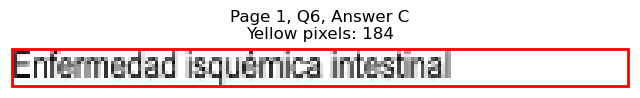

Page 1, Q6 - D: Detected box: x0=327.5, y0=419.4, x1=450.8, y1=430.4
Page 1, Q6, D: Yellow pixels: 1434
Page 1, Q6, D: Total non-white pixels: 2088
Page 1, Q6, D: Yellow percentage: 68.7%


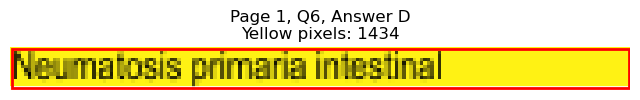


Page 1, Q6 - Selected Answer: D (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=469.8, x1=152.0, y1=480.8
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 387
Page 1, Q7, A: Yellow percentage: 0.0%


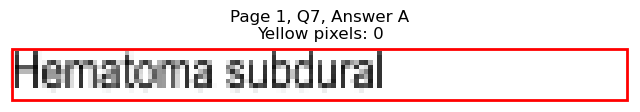

Page 1, Q7 - B: Detected box: x0=68.3, y0=482.5, x1=170.5, y1=493.5
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 522
Page 1, Q7, B: Yellow percentage: 0.0%


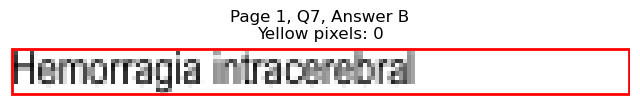

Page 1, Q7 - C: Detected box: x0=327.5, y0=469.8, x1=408.7, y1=480.8
Page 1, Q7, C: Yellow pixels: 1265
Page 1, Q7, C: Total non-white pixels: 1584
Page 1, Q7, C: Yellow percentage: 79.9%


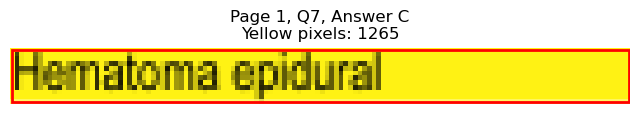

Page 1, Q7 - D: Detected box: x0=327.5, y0=482.5, x1=438.8, y1=493.5
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 577
Page 1, Q7, D: Yellow percentage: 0.0%


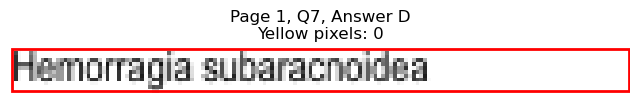


Page 1, Q7 - Selected Answer: C (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=532.9, x1=118.0, y1=543.9
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 270
Page 1, Q8, A: Yellow percentage: 0.0%


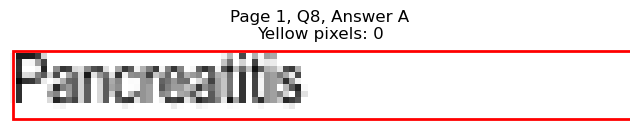

Page 1, Q8 - B: Detected box: x0=68.3, y0=545.5, x1=113.9, y1=556.5
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 246
Page 1, Q8, B: Yellow percentage: 0.0%


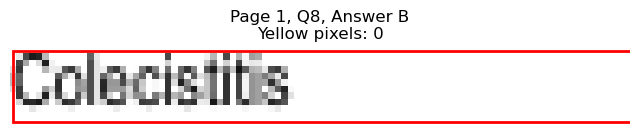

Page 1, Q8 - C: Detected box: x0=327.5, y0=532.9, x1=396.7, y1=543.9
Page 1, Q8, C: Yellow pixels: 1159
Page 1, Q8, C: Total non-white pixels: 1440
Page 1, Q8, C: Yellow percentage: 80.5%


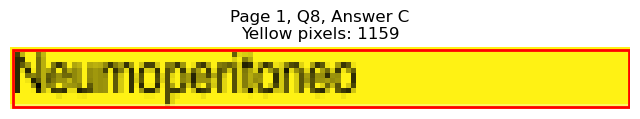

Page 1, Q8 - D: Detected box: x0=327.5, y0=545.5, x1=416.3, y1=556.5
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 456
Page 1, Q8, D: Yellow percentage: 0.0%


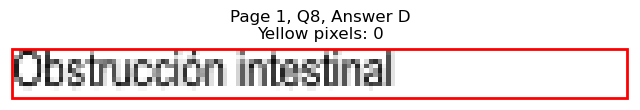


Page 1, Q8 - Selected Answer: C (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=596.0, x1=158.2, y1=607.0
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 473
Page 1, Q9, A: Yellow percentage: 0.0%


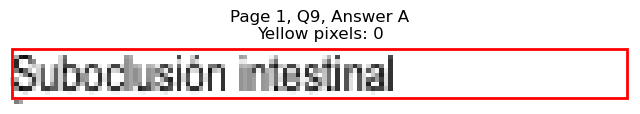

Page 1, Q9 - B: Detected box: x0=68.3, y0=608.6, x1=167.0, y1=619.6
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 494
Page 1, Q9, B: Yellow percentage: 0.0%


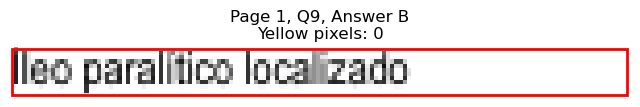

Page 1, Q9 - C: Detected box: x0=327.5, y0=596.0, x1=437.9, y1=607.0
Page 1, Q9, C: Yellow pixels: 1500
Page 1, Q9, C: Total non-white pixels: 1936
Page 1, Q9, C: Yellow percentage: 77.5%


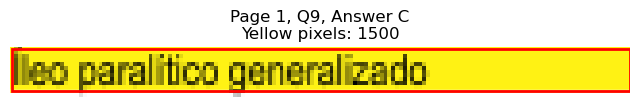

Page 1, Q9 - D: Detected box: x0=327.5, y0=545.5, x1=416.3, y1=556.5
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 456
Page 1, Q9, D: Yellow percentage: 0.0%


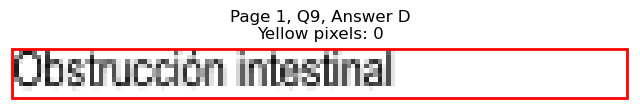


Page 1, Q9 - Selected Answer: C (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=68.3, y0=659.1, x1=103.9, y1=670.2
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 168
Page 1, Q10, A: Yellow percentage: 0.0%


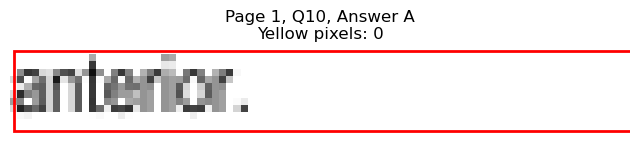

Page 1, Q10 - B: Detected box: x0=68.3, y0=671.7, x1=106.0, y1=682.8
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 189
Page 1, Q10, B: Yellow percentage: 0.0%


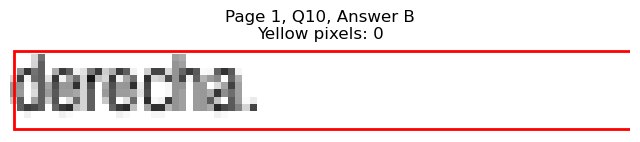

Page 1, Q10 - C: Detected box: x0=327.5, y0=659.1, x1=369.1, y1=670.2
Page 1, Q10, C: Yellow pixels: 856
Page 1, Q10, C: Total non-white pixels: 1025
Page 1, Q10, C: Yellow percentage: 83.5%


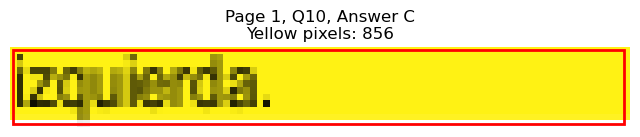

Page 1, Q10 - D: Detected box: x0=327.5, y0=671.7, x1=367.6, y1=682.8
Page 1, Q10, D: Yellow pixels: 0
Page 1, Q10, D: Total non-white pixels: 197
Page 1, Q10, D: Yellow percentage: 0.0%


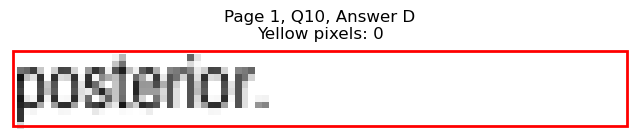


Page 1, Q10 - Selected Answer: C (based on yellow pixel count)




Page 1, Q11 - A: Detected box: x0=68.3, y0=722.2, x1=369.1, y1=733.3
Page 1, Q11, A: Yellow pixels: 0
Page 1, Q11, A: Total non-white pixels: 1536
Page 1, Q11, A: Yellow percentage: 0.0%


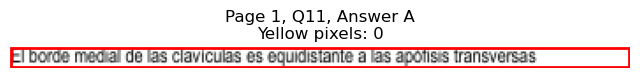

Page 1, Q11 - B: Detected box: x0=68.3, y0=734.8, x1=384.4, y1=745.9
Page 1, Q11, B: Yellow pixels: 0
Page 1, Q11, B: Total non-white pixels: 1961
Page 1, Q11, B: Yellow percentage: 0.0%


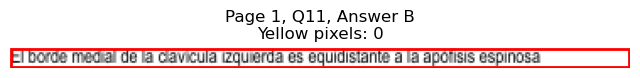

Page 1, Q11 - C: Detected box: x0=68.8, y0=747.4, x1=349.2, y1=758.5
Page 1, Q11, C: Yellow pixels: 2537
Page 1, Q11, C: Total non-white pixels: 3984
Page 1, Q11, C: Yellow percentage: 63.7%


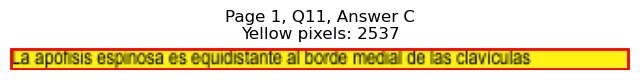

Page 1, Q11 - D: Detected box: x0=68.8, y0=760.2, x1=380.8, y1=771.2
Page 1, Q11, D: Yellow pixels: 0
Page 1, Q11, D: Total non-white pixels: 1572
Page 1, Q11, D: Yellow percentage: 0.0%


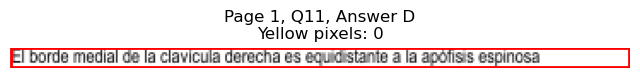


Page 1, Q11 - Selected Answer: C (based on yellow pixel count)





Page 2: Found 11 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=169.6, y1=127.4
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 524
Page 2, Q1, A: Yellow percentage: 0.0%


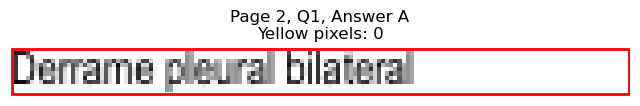

Page 2, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=166.1, y1=140.0
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 494
Page 2, Q1, B: Yellow percentage: 0.0%


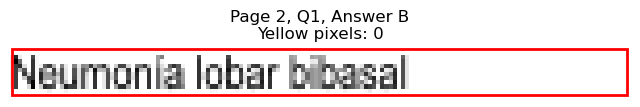

Page 2, Q1 - C: Detected box: x0=327.5, y0=116.4, x1=418.8, y1=127.4
Page 2, Q1, C: Yellow pixels: 1199
Page 2, Q1, C: Total non-white pixels: 1704
Page 2, Q1, C: Yellow percentage: 70.4%


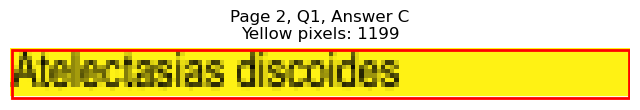

Page 2, Q1 - D: Detected box: x0=327.5, y0=129.0, x1=427.8, y1=140.0
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 555
Page 2, Q1, D: Yellow percentage: 0.0%


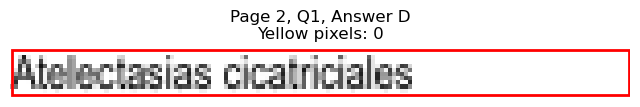


Page 2, Q1 - Selected Answer: C (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=192.1, x1=78.4, y1=203.1
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 32
Page 2, Q2, A: Yellow percentage: 0.0%


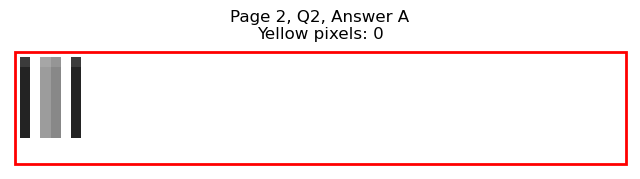

Page 2, Q2 - B: Detected box: x0=56.6, y0=204.7, x1=65.2, y1=215.7
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 50
Page 2, Q2, B: Yellow percentage: 0.0%


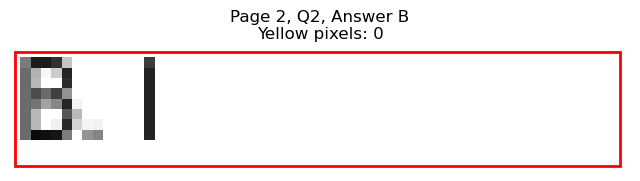

Page 2, Q2 - C: Detected box: x0=327.5, y0=192.1, x1=338.5, y1=203.1
Page 2, Q2, C: Yellow pixels: 62
Page 2, Q2, C: Total non-white pixels: 167
Page 2, Q2, C: Yellow percentage: 37.1%


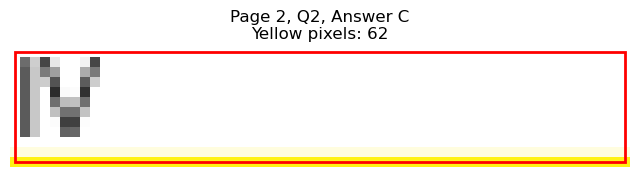

Page 2, Q2 - D: Detected box: x0=315.4, y0=204.7, x1=324.4, y1=215.7
Page 2, Q2, D: Yellow pixels: 670
Page 2, Q2, D: Total non-white pixels: 720
Page 2, Q2, D: Yellow percentage: 93.1%


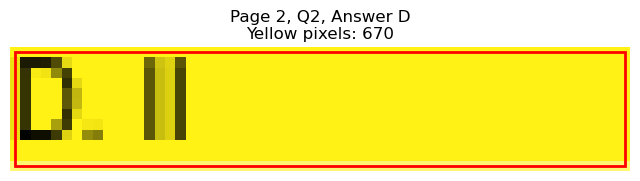


Page 2, Q2 - Selected Answer: D (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=255.2, x1=90.4, y1=266.2
Page 2, Q3, A: Yellow pixels: 732
Page 2, Q3, A: Total non-white pixels: 803
Page 2, Q3, A: Yellow percentage: 91.2%


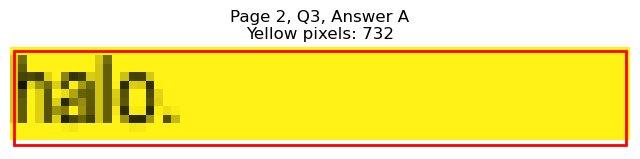

Page 2, Q3 - B: Detected box: x0=68.3, y0=267.8, x1=159.6, y1=278.8
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 419
Page 2, Q3, B: Yellow percentage: 0.0%


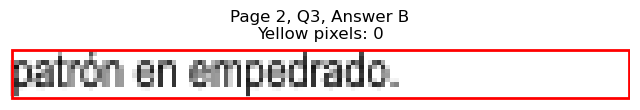

Page 2, Q3 - C: Detected box: x0=327.5, y0=255.2, x1=387.1, y1=266.2
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 291
Page 2, Q3, C: Yellow percentage: 0.0%


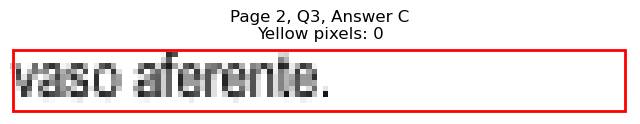

Page 2, Q3 - D: Detected box: x0=327.5, y0=267.8, x1=387.1, y1=278.8
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 271
Page 2, Q3, D: Yellow percentage: 0.0%


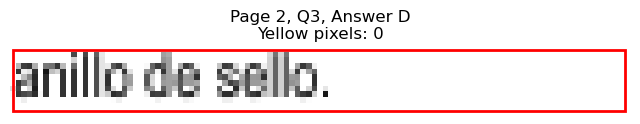


Page 2, Q3 - Selected Answer: A (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=330.9, x1=137.2, y1=342.0
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 362
Page 2, Q4, A: Yellow percentage: 0.0%


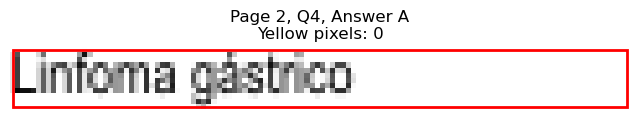

Page 2, Q4 - B: Detected box: x0=68.3, y0=343.6, x1=173.0, y1=354.7
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 535
Page 2, Q4, B: Yellow percentage: 0.0%


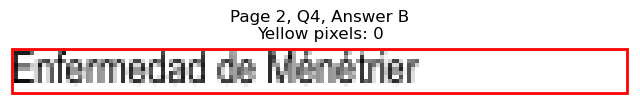

Page 2, Q4 - C: Detected box: x0=327.5, y0=330.9, x1=431.8, y1=342.0
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 714
Page 2, Q4, C: Yellow percentage: 0.0%


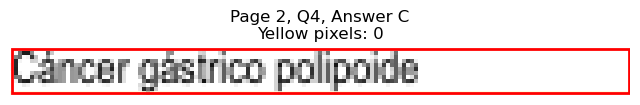

Page 2, Q4 - D: Detected box: x0=327.5, y0=343.6, x1=460.0, y1=354.7
Page 2, Q4, D: Yellow pixels: 1690
Page 2, Q4, D: Total non-white pixels: 2196
Page 2, Q4, D: Yellow percentage: 77.0%


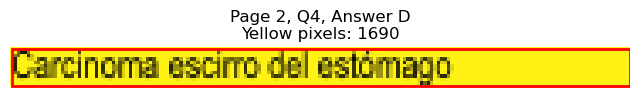


Page 2, Q4 - Selected Answer: D (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=406.6, x1=114.5, y1=417.7
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 223
Page 2, Q5, A: Yellow percentage: 0.0%


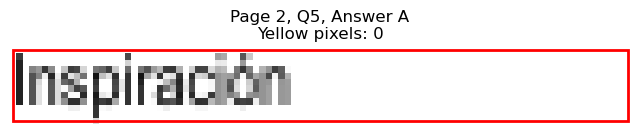

Page 2, Q5 - B: Detected box: x0=68.3, y0=419.4, x1=115.4, y1=430.4
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 249
Page 2, Q5, B: Yellow percentage: 0.0%


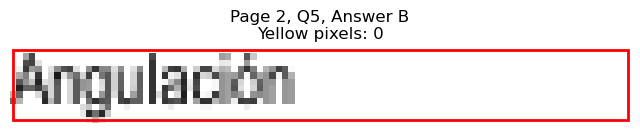

Page 2, Q5 - C: Detected box: x0=327.5, y0=406.6, x1=378.1, y1=417.7
Page 2, Q5, C: Yellow pixels: 1040
Page 2, Q5, C: Total non-white pixels: 1224
Page 2, Q5, C: Yellow percentage: 85.0%


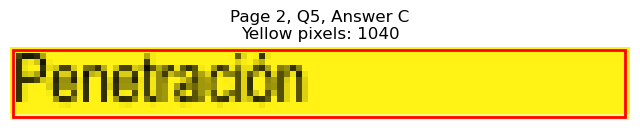

Page 2, Q5 - D: Detected box: x0=327.5, y0=419.4, x1=367.1, y1=430.4
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 193
Page 2, Q5, D: Yellow percentage: 0.0%


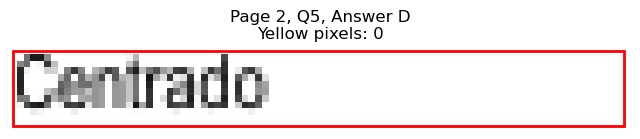


Page 2, Q5 - Selected Answer: C (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=469.8, x1=136.4, y1=480.8
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 308
Page 2, Q6, A: Yellow percentage: 0.0%


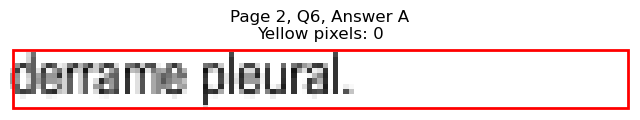

Page 2, Q6 - B: Detected box: x0=68.3, y0=482.5, x1=113.4, y1=493.5
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 230
Page 2, Q6, B: Yellow percentage: 0.0%


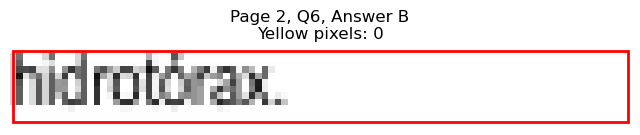

Page 2, Q6 - C: Detected box: x0=327.5, y0=469.8, x1=369.6, y1=480.8
Page 2, Q6, C: Yellow pixels: 953
Page 2, Q6, C: Total non-white pixels: 1116
Page 2, Q6, C: Yellow percentage: 85.4%


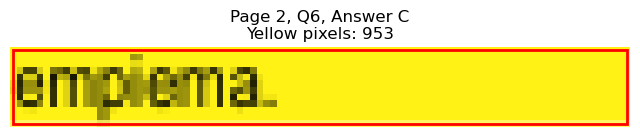

Page 2, Q6 - D: Detected box: x0=327.5, y0=482.5, x1=380.2, y1=493.5
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 227
Page 2, Q6, D: Yellow percentage: 0.0%


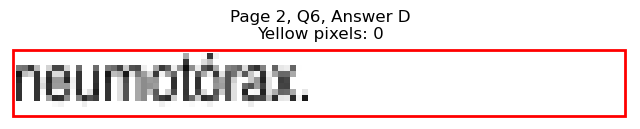


Page 2, Q6 - Selected Answer: C (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=520.3, x1=164.0, y1=531.3
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 491
Page 2, Q7, A: Yellow percentage: 0.0%


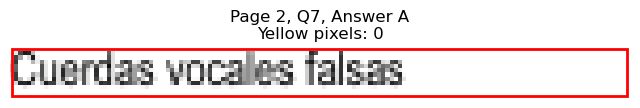

Page 2, Q7 - B: Detected box: x0=68.3, y0=532.9, x1=145.6, y1=543.9
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 408
Page 2, Q7, B: Yellow percentage: 0.0%


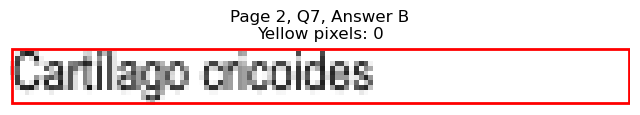

Page 2, Q7 - C: Detected box: x0=327.5, y0=520.3, x1=445.0, y1=531.3
Page 2, Q7, C: Yellow pixels: 1373
Page 2, Q7, C: Total non-white pixels: 2016
Page 2, Q7, C: Yellow percentage: 68.1%


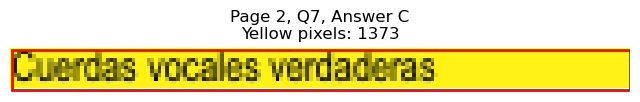

Page 2, Q7 - D: Detected box: x0=327.5, y0=532.9, x1=427.8, y1=543.9
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 530
Page 2, Q7, D: Yellow percentage: 0.0%


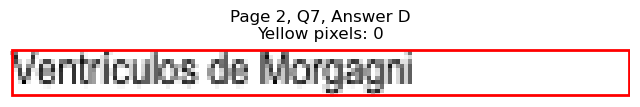


Page 2, Q7 - Selected Answer: C (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=570.8, x1=160.6, y1=581.8
Page 2, Q8, A: Yellow pixels: 1
Page 2, Q8, A: Total non-white pixels: 589
Page 2, Q8, A: Yellow percentage: 0.2%


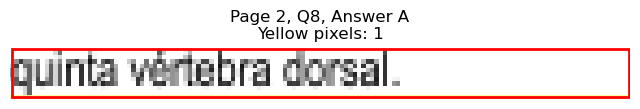

Page 2, Q8 - B: Detected box: x0=68.3, y0=583.4, x1=161.5, y1=594.4
Page 2, Q8, B: Yellow pixels: 1236
Page 2, Q8, B: Total non-white pixels: 1728
Page 2, Q8, B: Yellow percentage: 71.5%


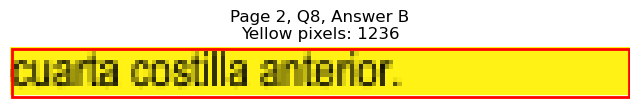

Page 2, Q8 - C: Detected box: x0=327.5, y0=570.8, x1=420.2, y1=581.8
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 467
Page 2, Q8, C: Yellow percentage: 0.0%


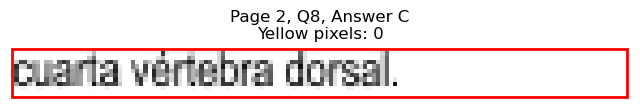

Page 2, Q8 - D: Detected box: x0=327.5, y0=583.4, x1=425.3, y1=594.4
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 497
Page 2, Q8, D: Yellow percentage: 0.0%


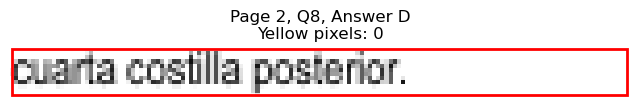


Page 2, Q8 - Selected Answer: B (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=646.5, x1=154.6, y1=657.6
Page 2, Q9, A: Yellow pixels: 1165
Page 2, Q9, A: Total non-white pixels: 1644
Page 2, Q9, A: Yellow percentage: 70.9%


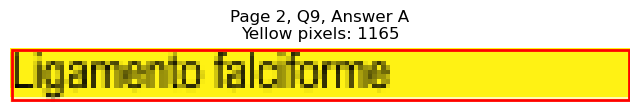

Page 2, Q9 - B: Detected box: x0=68.3, y0=659.1, x1=121.0, y1=670.2
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 232
Page 2, Q9, B: Yellow percentage: 0.0%


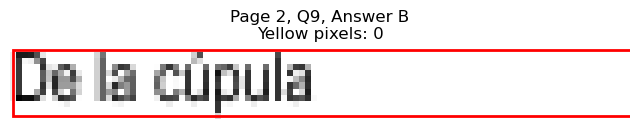

Page 2, Q9 - C: Detected box: x0=327.5, y0=646.5, x1=364.1, y1=657.6
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 221
Page 2, Q9, C: Yellow percentage: 0.0%


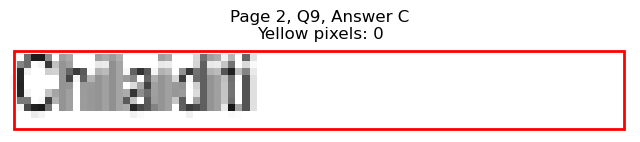

Page 2, Q9 - D: Detected box: x0=327.5, y0=659.1, x1=353.5, y1=670.2
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 152
Page 2, Q9, D: Yellow percentage: 0.0%


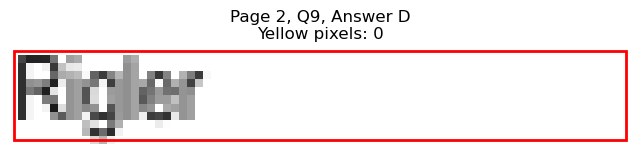


Page 2, Q9 - Selected Answer: A (based on yellow pixel count)




Page 2, Q10 - A: Detected box: x0=68.3, y0=697.0, x1=81.4, y1=708.1
Page 2, Q10, A: Yellow pixels: 64
Page 2, Q10, A: Total non-white pixels: 170
Page 2, Q10, A: Yellow percentage: 37.6%


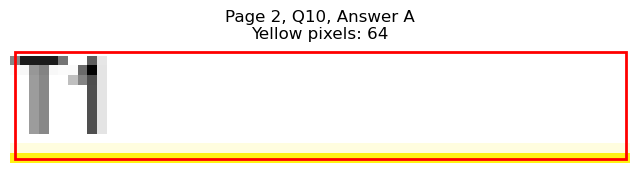

Page 2, Q10 - B: Detected box: x0=68.3, y0=709.6, x1=81.4, y1=720.7
Page 2, Q10, B: Yellow pixels: 727
Page 2, Q10, B: Total non-white pixels: 768
Page 2, Q10, B: Yellow percentage: 94.7%


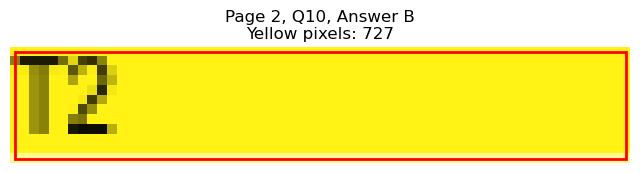

Page 2, Q10 - C: Detected box: x0=327.5, y0=697.0, x1=362.6, y1=708.1
Page 2, Q10, C: Yellow pixels: 0
Page 2, Q10, C: Total non-white pixels: 184
Page 2, Q10, C: Yellow percentage: 0.0%


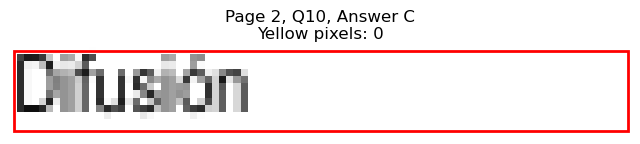

Page 2, Q10 - D: Detected box: x0=327.5, y0=709.6, x1=349.1, y1=720.7
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 101
Page 2, Q10, D: Yellow percentage: 0.0%


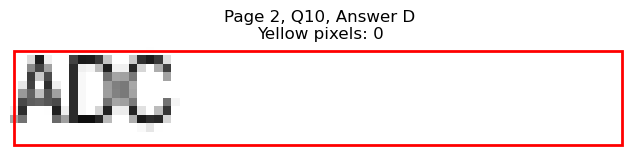


Page 2, Q10 - Selected Answer: B (based on yellow pixel count)




Page 2, Q11 - A: Detected box: x0=68.3, y0=747.4, x1=140.0, y1=758.5
Page 2, Q11, A: Yellow pixels: 0
Page 2, Q11, A: Total non-white pixels: 364
Page 2, Q11, A: Yellow percentage: 0.0%


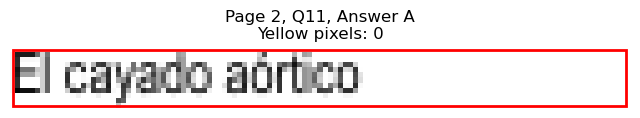

Page 2, Q11 - B: Detected box: x0=68.3, y0=760.2, x1=153.1, y1=771.2
Page 2, Q11, B: Yellow pixels: 0
Page 2, Q11, B: Total non-white pixels: 419
Page 2, Q11, B: Yellow percentage: 0.0%


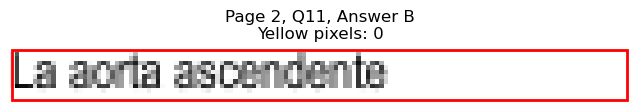

Page 2, Q11 - C: Detected box: x0=327.5, y0=747.4, x1=372.6, y1=758.5
Page 2, Q11, C: Yellow pixels: 874
Page 2, Q11, C: Total non-white pixels: 1152
Page 2, Q11, C: Yellow percentage: 75.9%


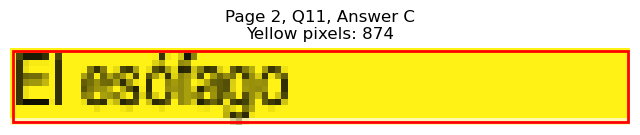

Page 2, Q11 - D: Detected box: x0=327.5, y0=760.2, x1=429.4, y1=771.2
Page 2, Q11, D: Yellow pixels: 0
Page 2, Q11, D: Total non-white pixels: 529
Page 2, Q11, D: Yellow percentage: 0.0%


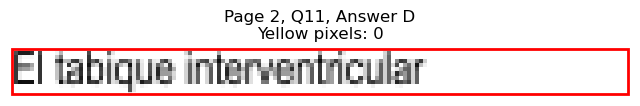


Page 2, Q11 - Selected Answer: C (based on yellow pixel count)





Page 3: Found 11 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=198.2, y1=102.2
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 653
Page 3, Q1, A: Yellow percentage: 0.0%


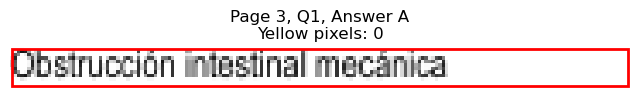

Page 3, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=155.0, y1=114.8
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 439
Page 3, Q1, B: Yellow percentage: 0.0%


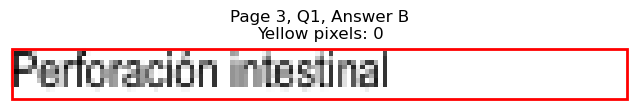

Page 3, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=410.3, y1=102.2
Page 3, Q1, C: Yellow pixels: 134
Page 3, Q1, C: Total non-white pixels: 717
Page 3, Q1, C: Yellow percentage: 18.7%


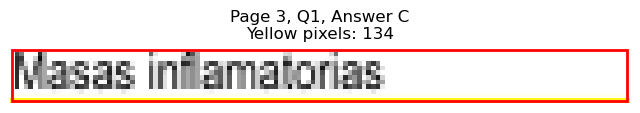

Page 3, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=466.9, y1=114.8
Page 3, Q1, D: Yellow pixels: 1748
Page 3, Q1, D: Total non-white pixels: 2280
Page 3, Q1, D: Yellow percentage: 76.7%


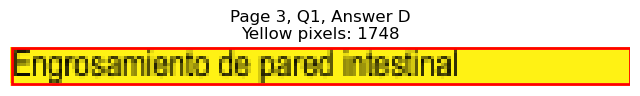


Page 3, Q1 - Selected Answer: D (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=56.6, y0=192.1, x1=97.9, y1=203.1
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 463
Page 3, Q2, A: Yellow percentage: 0.0%


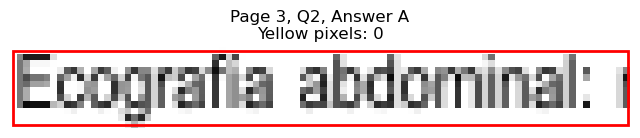

Page 3, Q2 - B: Detected box: x0=68.3, y0=154.3, x1=170.2, y1=165.3
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 546
Page 3, Q2, B: Yellow percentage: 0.0%


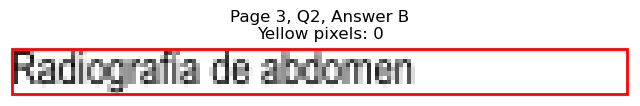

Page 3, Q2 - C: Detected box: x0=327.5, y0=141.7, x1=367.6, y1=152.7
Page 3, Q2, C: Yellow pixels: 958
Page 3, Q2, C: Total non-white pixels: 1092
Page 3, Q2, C: Yellow percentage: 87.7%


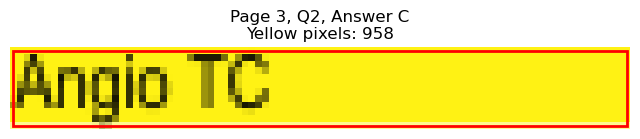

Page 3, Q2 - D: Detected box: x0=327.5, y0=154.3, x1=395.6, y1=165.3
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 314
Page 3, Q2, D: Yellow percentage: 0.0%


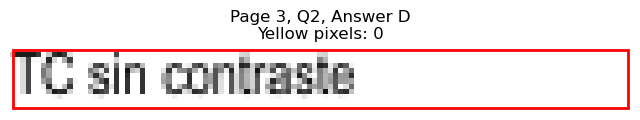


Page 3, Q2 - Selected Answer: C (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=217.4, x1=100.4, y1=228.4
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 161
Page 3, Q3, A: Yellow percentage: 0.0%


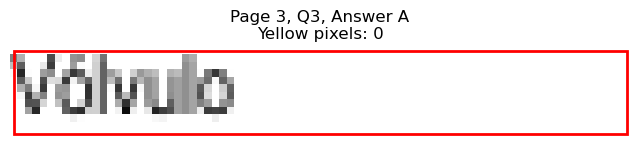

Page 3, Q3 - B: Detected box: x0=68.3, y0=230.0, x1=148.6, y1=241.0
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 420
Page 3, Q3, B: Yellow percentage: 0.0%


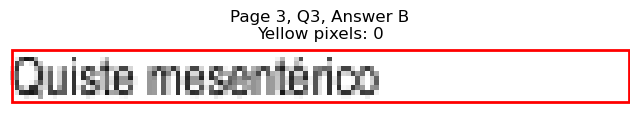

Page 3, Q3 - C: Detected box: x0=327.5, y0=217.4, x1=413.8, y1=228.4
Page 3, Q3, C: Yellow pixels: 137
Page 3, Q3, C: Total non-white pixels: 575
Page 3, Q3, C: Yellow percentage: 23.8%


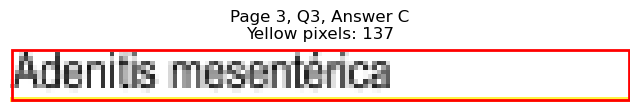

Page 3, Q3 - D: Detected box: x0=327.5, y0=230.0, x1=390.2, y1=241.0
Page 3, Q3, D: Yellow pixels: 1125
Page 3, Q3, D: Total non-white pixels: 1370
Page 3, Q3, D: Yellow percentage: 82.1%


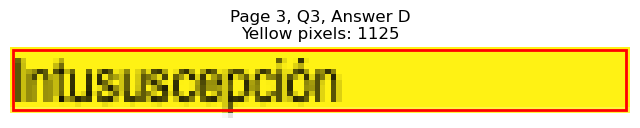


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=293.1, x1=134.5, y1=304.2
Page 3, Q4, A: Yellow pixels: 1045
Page 3, Q4, A: Total non-white pixels: 1289
Page 3, Q4, A: Yellow percentage: 81.1%


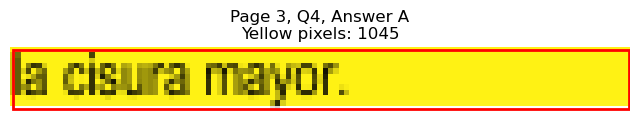

Page 3, Q4 - B: Detected box: x0=68.3, y0=305.7, x1=139.0, y1=316.8
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 333
Page 3, Q4, B: Yellow percentage: 0.0%


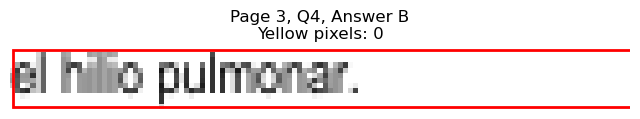

Page 3, Q4 - C: Detected box: x0=327.5, y0=293.1, x1=419.8, y1=304.2
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 456
Page 3, Q4, C: Yellow percentage: 0.0%


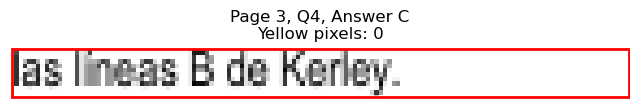

Page 3, Q4 - D: Detected box: x0=327.5, y0=305.7, x1=394.2, y1=316.8
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 299
Page 3, Q4, D: Yellow percentage: 0.0%


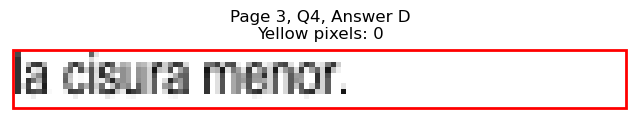


Page 3, Q4 - Selected Answer: A (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=343.6, x1=155.5, y1=354.7
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 434
Page 3, Q5, A: Yellow percentage: 0.0%


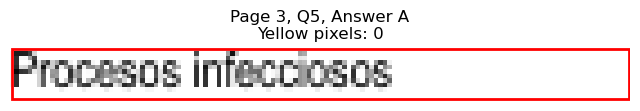

Page 3, Q5 - B: Detected box: x0=68.3, y0=356.2, x1=180.1, y1=367.3
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 591
Page 3, Q5, B: Yellow percentage: 0.0%


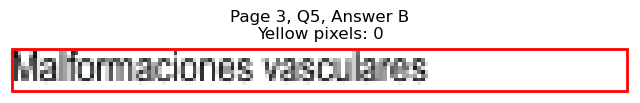

Page 3, Q5 - C: Detected box: x0=327.5, y0=343.6, x1=373.1, y1=354.7
Page 3, Q5, C: Yellow pixels: 969
Page 3, Q5, C: Total non-white pixels: 1164
Page 3, Q5, C: Yellow percentage: 83.2%


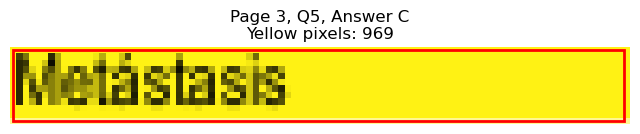

Page 3, Q5 - D: Detected box: x0=327.5, y0=356.2, x1=362.0, y1=367.3
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 145
Page 3, Q5, D: Yellow percentage: 0.0%


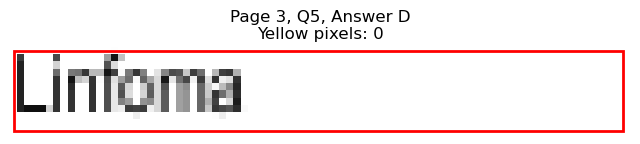


Page 3, Q5 - Selected Answer: C (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=419.4, x1=137.0, y1=430.4
Page 3, Q6, A: Yellow pixels: 120
Page 3, Q6, A: Total non-white pixels: 490
Page 3, Q6, A: Yellow percentage: 24.5%


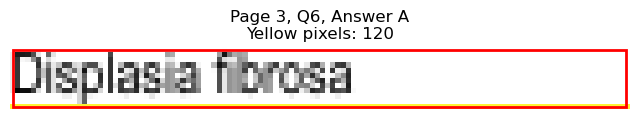

Page 3, Q6 - B: Detected box: x0=68.3, y0=432.0, x1=126.5, y1=443.0
Page 3, Q6, B: Yellow pixels: 1078
Page 3, Q6, B: Total non-white pixels: 1308
Page 3, Q6, B: Yellow percentage: 82.4%


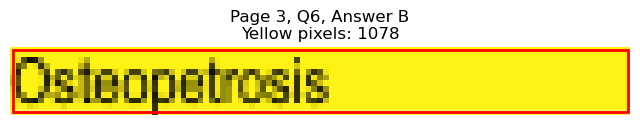

Page 3, Q6 - C: Detected box: x0=327.5, y0=419.4, x1=429.8, y1=430.4
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 556
Page 3, Q6, C: Yellow percentage: 0.0%


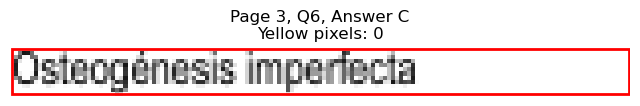

Page 3, Q6 - D: Detected box: x0=327.5, y0=432.0, x1=381.1, y1=443.0
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 255
Page 3, Q6, D: Yellow percentage: 0.0%


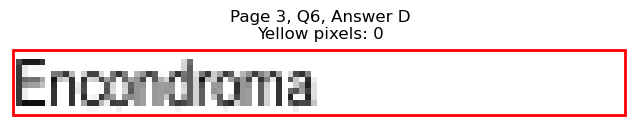


Page 3, Q6 - Selected Answer: B (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=469.8, x1=109.4, y1=480.8
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 200
Page 3, Q7, A: Yellow percentage: 0.0%


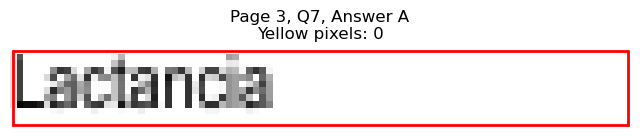

Page 3, Q7 - B: Detected box: x0=68.3, y0=482.5, x1=112.0, y1=493.5
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 227
Page 3, Q7, B: Yellow percentage: 0.0%


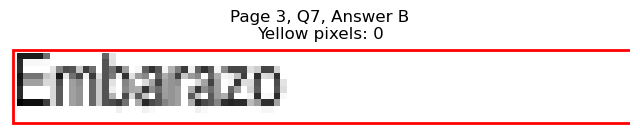

Page 3, Q7 - C: Detected box: x0=327.5, y0=469.8, x1=404.6, y1=480.8
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 524
Page 3, Q7, C: Yellow percentage: 0.0%


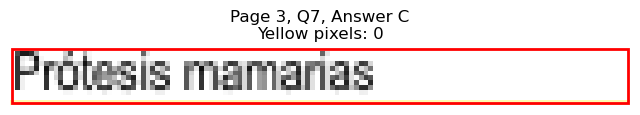

Page 3, Q7 - D: Detected box: x0=327.5, y0=482.5, x1=398.6, y1=493.5
Page 3, Q7, D: Yellow pixels: 1039
Page 3, Q7, D: Total non-white pixels: 1464
Page 3, Q7, D: Yellow percentage: 71.0%


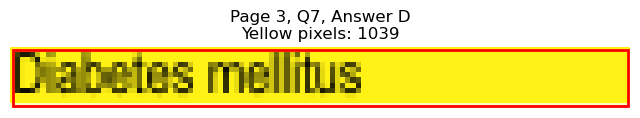


Page 3, Q7 - Selected Answer: D (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=532.9, x1=241.2, y1=543.9
Page 3, Q8, A: Yellow pixels: 1884
Page 3, Q8, A: Total non-white pixels: 2568
Page 3, Q8, A: Yellow percentage: 73.4%


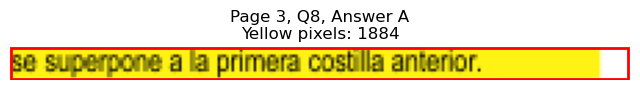

Page 3, Q8 - B: Detected box: x0=68.3, y0=545.5, x1=245.8, y1=556.5
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 871
Page 3, Q8, B: Yellow percentage: 0.0%


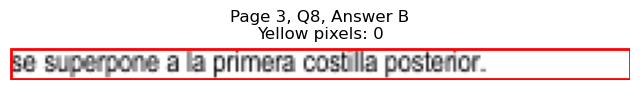

Page 3, Q8 - C: Detected box: x0=327.5, y0=532.9, x1=488.0, y1=543.9
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 812
Page 3, Q8, C: Yellow percentage: 0.0%


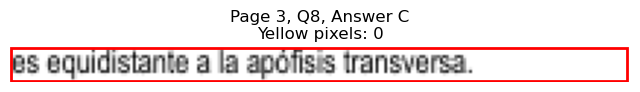

Page 3, Q8 - D: Detected box: x0=327.5, y0=545.5, x1=481.9, y1=556.5
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 786
Page 3, Q8, D: Yellow percentage: 0.0%


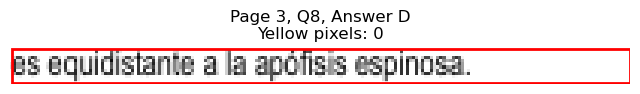


Page 3, Q8 - Selected Answer: A (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=68.3, y0=608.6, x1=166.6, y1=619.6
Page 3, Q9, A: Yellow pixels: 1396
Page 3, Q9, A: Total non-white pixels: 1788
Page 3, Q9, A: Yellow percentage: 78.1%


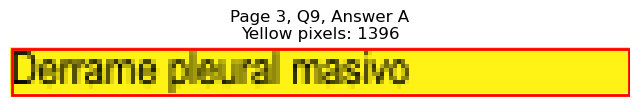

Page 3, Q9 - B: Detected box: x0=68.3, y0=621.3, x1=187.7, y1=632.4
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 598
Page 3, Q9, B: Yellow percentage: 0.0%


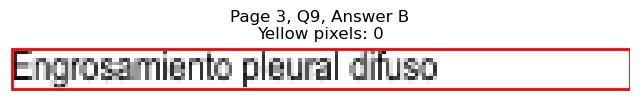

Page 3, Q9 - C: Detected box: x0=327.5, y0=608.6, x1=401.2, y1=619.6
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 374
Page 3, Q9, C: Yellow percentage: 0.0%


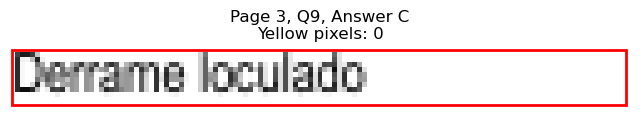

Page 3, Q9 - D: Detected box: x0=327.5, y0=621.3, x1=429.2, y1=632.4
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 550
Page 3, Q9, D: Yellow percentage: 0.0%


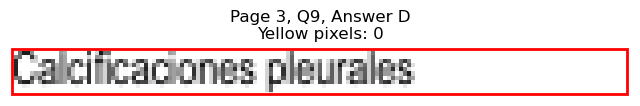


Page 3, Q9 - Selected Answer: A (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=68.3, y0=671.7, x1=136.9, y1=682.8
Page 3, Q10, A: Yellow pixels: 119
Page 3, Q10, A: Total non-white pixels: 476
Page 3, Q10, A: Yellow percentage: 25.0%


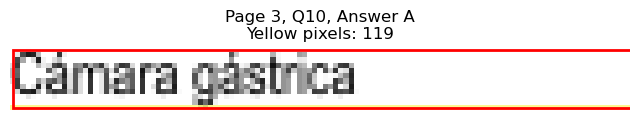

Page 3, Q10 - B: Detected box: x0=68.3, y0=684.3, x1=171.1, y1=695.4
Page 3, Q10, B: Yellow pixels: 1306
Page 3, Q10, B: Total non-white pixels: 1848
Page 3, Q10, B: Yellow percentage: 70.7%


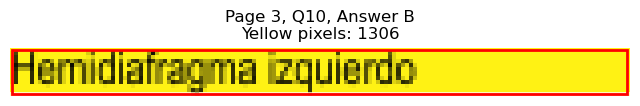

Page 3, Q10 - C: Detected box: x0=327.5, y0=671.7, x1=426.2, y1=682.8
Page 3, Q10, C: Yellow pixels: 0
Page 3, Q10, C: Total non-white pixels: 520
Page 3, Q10, C: Yellow percentage: 0.0%


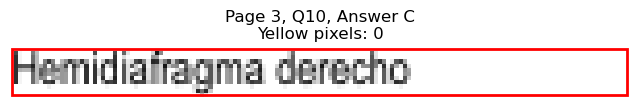

Page 3, Q10 - D: Detected box: x0=327.5, y0=684.3, x1=437.3, y1=695.4
Page 3, Q10, D: Yellow pixels: 0
Page 3, Q10, D: Total non-white pixels: 540
Page 3, Q10, D: Yellow percentage: 0.0%


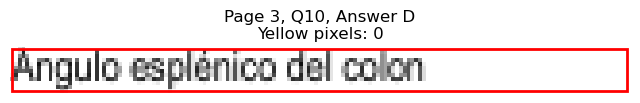


Page 3, Q10 - Selected Answer: B (based on yellow pixel count)




Page 3, Q11 - A: Detected box: x0=68.3, y0=722.2, x1=236.8, y1=733.3
Page 3, Q11, A: Yellow pixels: 0
Page 3, Q11, A: Total non-white pixels: 857
Page 3, Q11, A: Yellow percentage: 0.0%


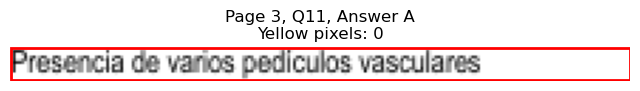

Page 3, Q11 - B: Detected box: x0=68.3, y0=734.8, x1=188.2, y1=745.9
Page 3, Q11, B: Yellow pixels: 0
Page 3, Q11, B: Total non-white pixels: 583
Page 3, Q11, B: Yellow percentage: 0.0%


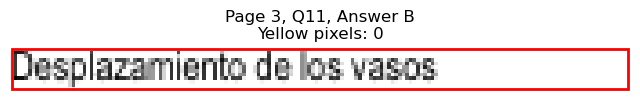

Page 3, Q11 - C: Detected box: x0=327.5, y0=722.2, x1=440.9, y1=733.3
Page 3, Q11, C: Yellow pixels: 164
Page 3, Q11, C: Total non-white pixels: 714
Page 3, Q11, C: Yellow percentage: 23.0%


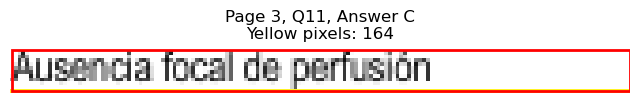

Page 3, Q11 - D: Detected box: x0=327.5, y0=734.8, x1=465.5, y1=745.9
Page 3, Q11, D: Yellow pixels: 1728
Page 3, Q11, D: Total non-white pixels: 2268
Page 3, Q11, D: Yellow percentage: 76.2%


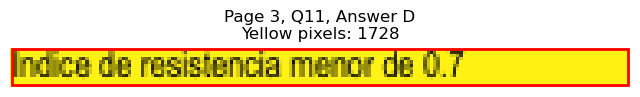


Page 3, Q11 - Selected Answer: D (based on yellow pixel count)





Page 4: Found 10 questions
Page 4, Q1 - A: Detected box: x0=56.6, y0=103.8, x1=65.2, y1=114.8
Page 4, Q1, A: Yellow pixels: 668
Page 4, Q1, A: Total non-white pixels: 720
Page 4, Q1, A: Yellow percentage: 92.8%


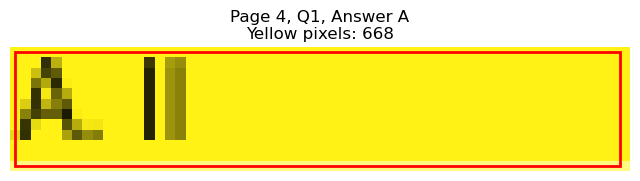

Page 4, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=79.3, y1=127.4
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 36
Page 4, Q1, B: Yellow percentage: 0.0%


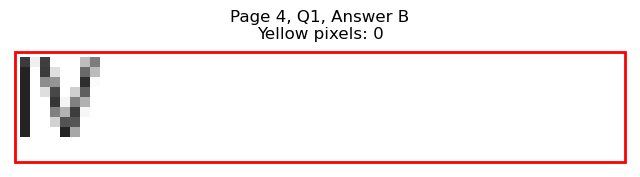

Page 4, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=337.6, y1=114.8
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 48
Page 4, Q1, C: Yellow percentage: 0.0%


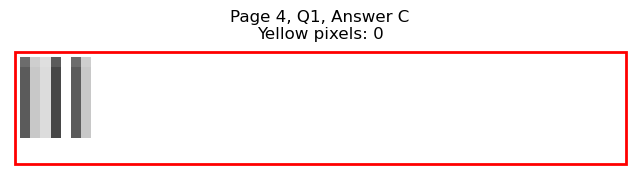

Page 4, Q1 - D: Detected box: x0=315.4, y0=116.4, x1=324.4, y1=127.4
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 58
Page 4, Q1, D: Yellow percentage: 0.0%


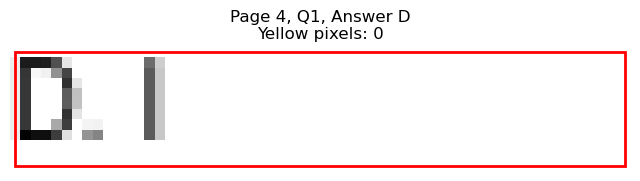


Page 4, Q1 - Selected Answer: A (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=56.6, y0=166.9, x1=65.2, y1=177.9
Page 4, Q2, A: Yellow pixels: 674
Page 4, Q2, A: Total non-white pixels: 720
Page 4, Q2, A: Yellow percentage: 93.6%


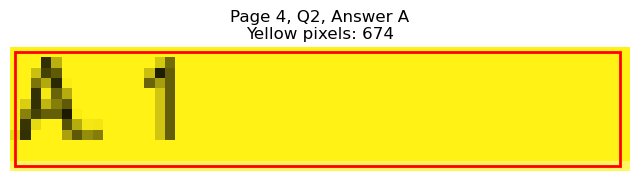

Page 4, Q2 - B: Detected box: x0=56.6, y0=179.5, x1=65.2, y1=190.5
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 73
Page 4, Q2, B: Yellow percentage: 0.0%


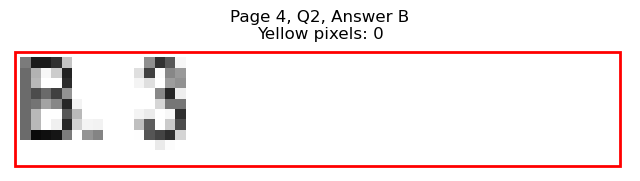

Page 4, Q2 - C: Detected box: x0=315.4, y0=166.9, x1=324.4, y1=177.9
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 64
Page 4, Q2, C: Yellow percentage: 0.0%


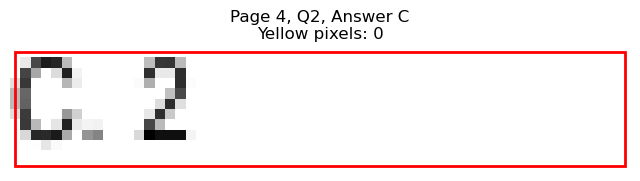

Page 4, Q2 - D: Detected box: x0=315.4, y0=179.5, x1=324.4, y1=190.5
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 71
Page 4, Q2, D: Yellow percentage: 0.0%


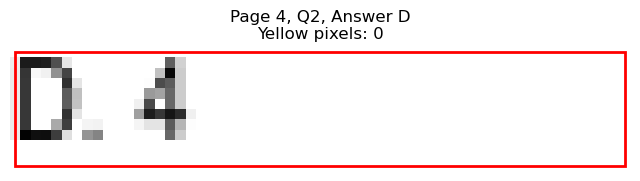


Page 4, Q2 - Selected Answer: A (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=217.4, x1=229.8, y1=228.4
Page 4, Q3, A: Yellow pixels: 212
Page 4, Q3, A: Total non-white pixels: 1040
Page 4, Q3, A: Yellow percentage: 20.4%


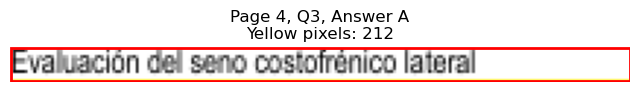

Page 4, Q3 - B: Detected box: x0=68.3, y0=230.0, x1=297.5, y1=241.0
Page 4, Q3, B: Yellow pixels: 2496
Page 4, Q3, B: Total non-white pixels: 3367
Page 4, Q3, B: Yellow percentage: 74.1%


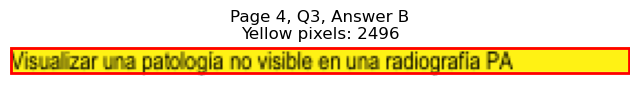

Page 4, Q3 - C: Detected box: x0=68.8, y0=242.6, x1=285.8, y1=253.6
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 1044
Page 4, Q3, C: Yellow percentage: 0.0%


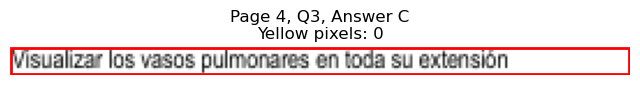

Page 4, Q3 - D: Detected box: x0=68.8, y0=255.2, x1=199.7, y1=266.2
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 699
Page 4, Q3, D: Yellow percentage: 0.0%


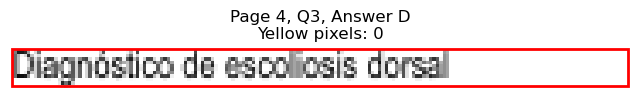


Page 4, Q3 - Selected Answer: B (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=318.3, x1=139.0, y1=329.4
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 367
Page 4, Q4, A: Yellow percentage: 0.0%


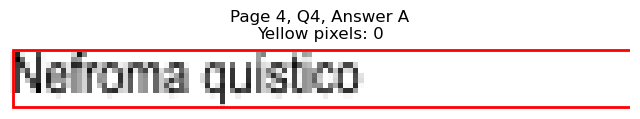

Page 4, Q4 - B: Detected box: x0=68.3, y0=330.9, x1=100.4, y1=342.0
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 158
Page 4, Q4, B: Yellow percentage: 0.0%


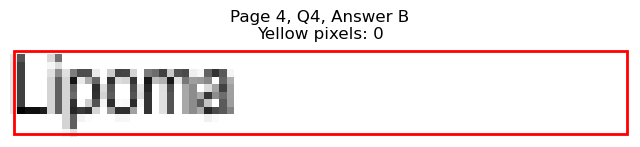

Page 4, Q4 - C: Detected box: x0=327.5, y0=318.3, x1=378.1, y1=329.4
Page 4, Q4, C: Yellow pixels: 940
Page 4, Q4, C: Total non-white pixels: 1224
Page 4, Q4, C: Yellow percentage: 76.8%


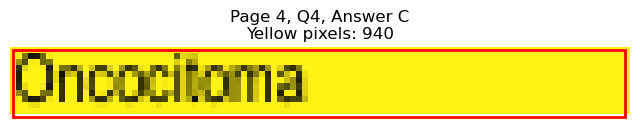

Page 4, Q4 - D: Detected box: x0=327.5, y0=330.9, x1=362.0, y1=342.0
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 145
Page 4, Q4, D: Yellow percentage: 0.0%


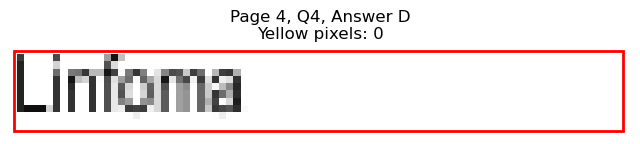


Page 4, Q4 - Selected Answer: C (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=368.8, x1=122.4, y1=379.9
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 380
Page 4, Q5, A: Yellow percentage: 0.0%


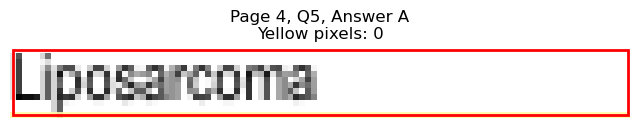

Page 4, Q5 - B: Detected box: x0=68.3, y0=381.4, x1=135.0, y1=392.5
Page 4, Q5, B: Yellow pixels: 1050
Page 4, Q5, B: Total non-white pixels: 1404
Page 4, Q5, B: Yellow percentage: 74.8%


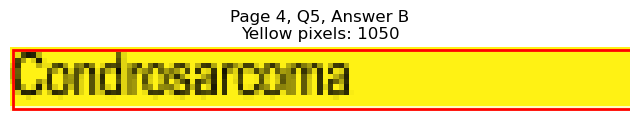

Page 4, Q5 - C: Detected box: x0=327.5, y0=368.8, x1=388.7, y1=379.9
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 307
Page 4, Q5, C: Yellow percentage: 0.0%


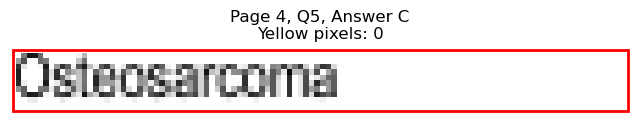

Page 4, Q5 - D: Detected box: x0=327.5, y0=381.4, x1=387.7, y1=392.5
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 292
Page 4, Q5, D: Yellow percentage: 0.0%


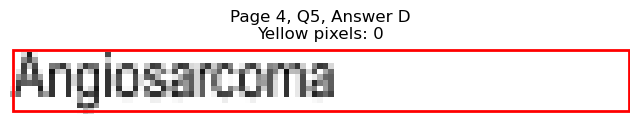


Page 4, Q5 - Selected Answer: B (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=419.4, x1=99.4, y1=430.4
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 169
Page 4, Q6, A: Yellow percentage: 0.0%


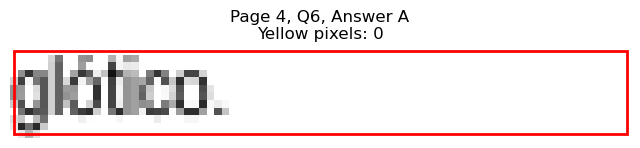

Page 4, Q6 - B: Detected box: x0=68.3, y0=432.0, x1=113.9, y1=443.0
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 244
Page 4, Q6, B: Yellow percentage: 0.0%


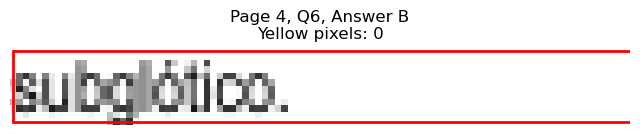

Page 4, Q6 - C: Detected box: x0=327.5, y0=419.4, x1=381.1, y1=430.4
Page 4, Q6, C: Yellow pixels: 926
Page 4, Q6, C: Total non-white pixels: 1260
Page 4, Q6, C: Yellow percentage: 73.5%


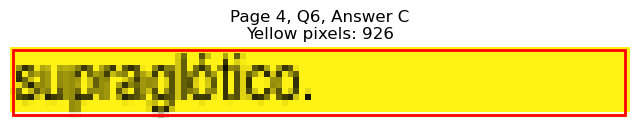

Page 4, Q6 - D: Detected box: x0=327.5, y0=432.0, x1=382.7, y1=443.0
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 264
Page 4, Q6, D: Yellow percentage: 0.0%


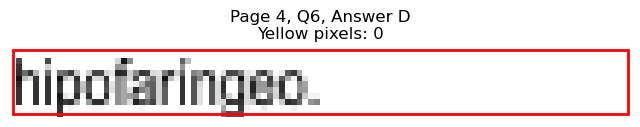


Page 4, Q6 - Selected Answer: C (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=507.7, x1=255.8, y1=518.7
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 1015
Page 4, Q7, A: Yellow percentage: 0.0%


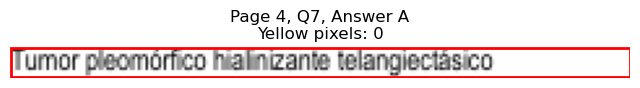

Page 4, Q7 - B: Detected box: x0=68.3, y0=520.3, x1=183.1, y1=531.3
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 584
Page 4, Q7, B: Yellow percentage: 0.0%


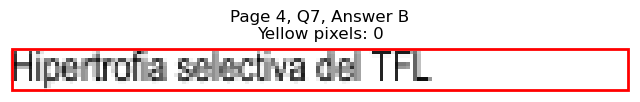

Page 4, Q7 - C: Detected box: x0=327.5, y0=507.7, x1=431.8, y1=518.7
Page 4, Q7, C: Yellow pixels: 1507
Page 4, Q7, C: Total non-white pixels: 1860
Page 4, Q7, C: Yellow percentage: 81.0%


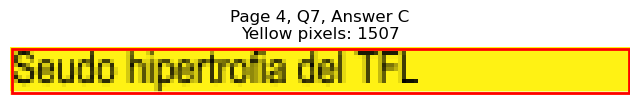

Page 4, Q7 - D: Detected box: x0=327.5, y0=520.3, x1=511.1, y1=531.3
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 967
Page 4, Q7, D: Yellow percentage: 0.0%


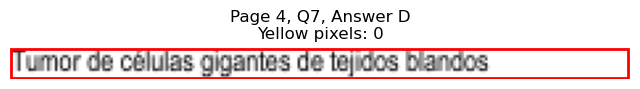


Page 4, Q7 - Selected Answer: C (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=583.4, x1=163.6, y1=594.4
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 493
Page 4, Q8, A: Yellow percentage: 0.0%


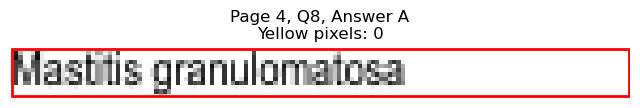

Page 4, Q8 - B: Detected box: x0=68.3, y0=596.0, x1=137.6, y1=607.0
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 332
Page 4, Q8, B: Yellow percentage: 0.0%


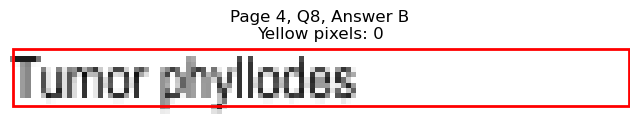

Page 4, Q8 - C: Detected box: x0=327.5, y0=583.4, x1=422.8, y1=594.4
Page 4, Q8, C: Yellow pixels: 146
Page 4, Q8, C: Total non-white pixels: 624
Page 4, Q8, C: Yellow percentage: 23.4%


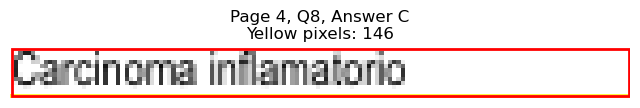

Page 4, Q8 - D: Detected box: x0=327.5, y0=596.0, x1=452.9, y1=607.0
Page 4, Q8, D: Yellow pixels: 1659
Page 4, Q8, D: Total non-white pixels: 2114
Page 4, Q8, D: Yellow percentage: 78.5%


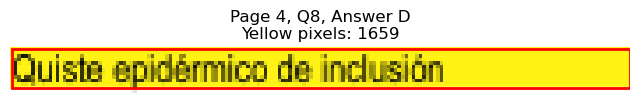


Page 4, Q8 - Selected Answer: D (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=646.5, x1=147.5, y1=657.6
Page 4, Q9, A: Yellow pixels: 130
Page 4, Q9, A: Total non-white pixels: 497
Page 4, Q9, A: Yellow percentage: 26.2%


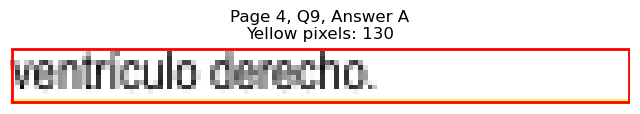

Page 4, Q9 - B: Detected box: x0=68.3, y0=659.1, x1=144.5, y1=670.2
Page 4, Q9, B: Yellow pixels: 1141
Page 4, Q9, B: Total non-white pixels: 1398
Page 4, Q9, B: Yellow percentage: 81.6%


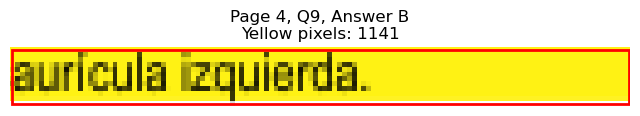

Page 4, Q9 - C: Detected box: x0=327.5, y0=646.5, x1=410.8, y1=657.6
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 416
Page 4, Q9, C: Yellow percentage: 0.0%


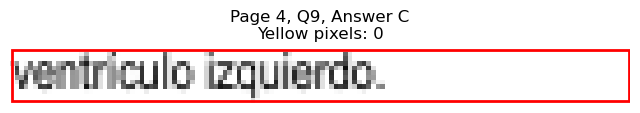

Page 4, Q9 - D: Detected box: x0=327.5, y0=659.1, x1=399.7, y1=670.2
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 347
Page 4, Q9, D: Yellow percentage: 0.0%


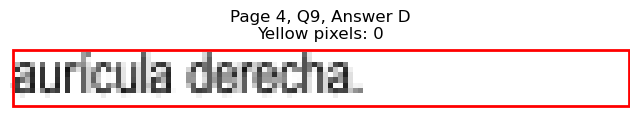


Page 4, Q9 - Selected Answer: B (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=68.3, y0=697.0, x1=175.1, y1=708.1
Page 4, Q10, A: Yellow pixels: 0
Page 4, Q10, A: Total non-white pixels: 549
Page 4, Q10, A: Yellow percentage: 0.0%


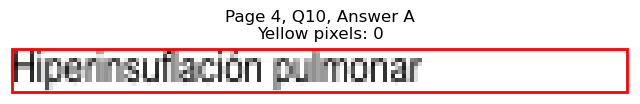

Page 4, Q10 - B: Detected box: x0=68.3, y0=709.6, x1=258.4, y1=720.7
Page 4, Q10, B: Yellow pixels: 0
Page 4, Q10, B: Total non-white pixels: 961
Page 4, Q10, B: Yellow percentage: 0.0%


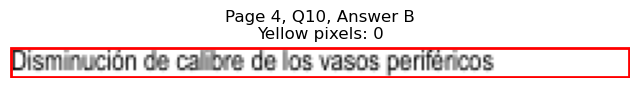

Page 4, Q10 - C: Detected box: x0=327.5, y0=697.0, x1=350.0, y1=708.1
Page 4, Q10, C: Yellow pixels: 736
Page 4, Q10, C: Total non-white pixels: 814
Page 4, Q10, C: Yellow percentage: 90.4%


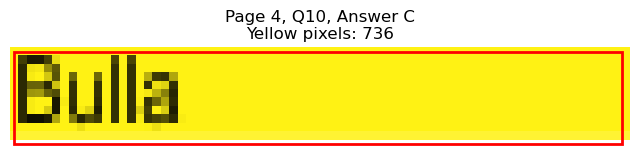

Page 4, Q10 - D: Detected box: x0=327.5, y0=709.6, x1=409.2, y1=720.7
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 426
Page 4, Q10, D: Yellow percentage: 0.0%


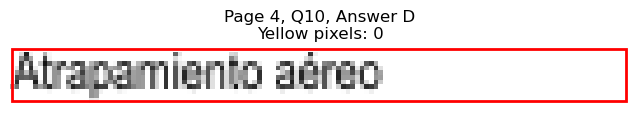


Page 4, Q10 - Selected Answer: C (based on yellow pixel count)





Page 5: Found 11 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=155.0, y1=114.8
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 422
Page 5, Q1, A: Yellow percentage: 0.0%


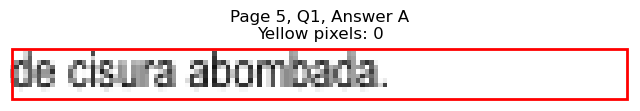

Page 5, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=135.5, y1=127.4
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 319
Page 5, Q1, B: Yellow percentage: 0.0%


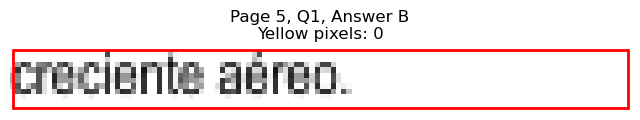

Page 5, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=406.2, y1=114.8
Page 5, Q1, C: Yellow pixels: 130
Page 5, Q1, C: Total non-white pixels: 493
Page 5, Q1, C: Yellow percentage: 26.4%


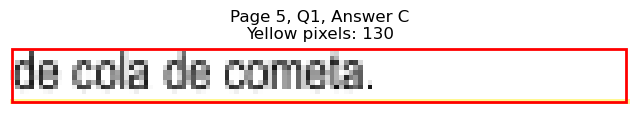

Page 5, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=371.6, y1=127.4
Page 5, Q1, D: Yellow pixels: 899
Page 5, Q1, D: Total non-white pixels: 1140
Page 5, Q1, D: Yellow percentage: 78.9%


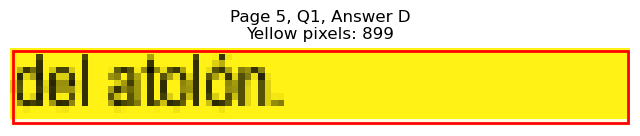


Page 5, Q1 - Selected Answer: D (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=154.3, x1=118.0, y1=165.3
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 279
Page 5, Q2, A: Yellow percentage: 0.0%


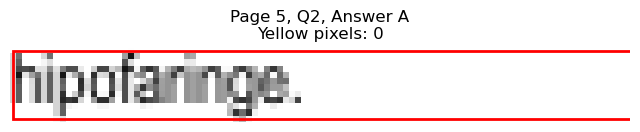

Page 5, Q2 - B: Detected box: x0=68.3, y0=166.9, x1=120.5, y1=177.9
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 252
Page 5, Q2, B: Yellow percentage: 0.0%


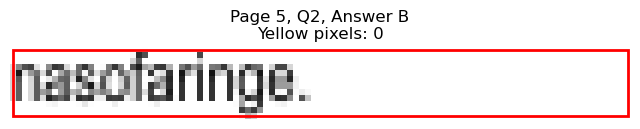

Page 5, Q2 - C: Detected box: x0=327.5, y0=154.3, x1=373.1, y1=165.3
Page 5, Q2, C: Yellow pixels: 892
Page 5, Q2, C: Total non-white pixels: 1164
Page 5, Q2, C: Yellow percentage: 76.6%


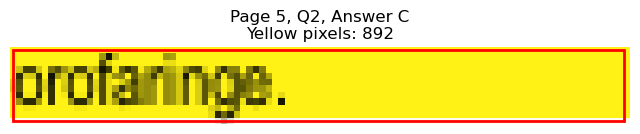

Page 5, Q2 - D: Detected box: x0=327.5, y0=166.9, x1=390.1, y1=177.9
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 306
Page 5, Q2, D: Yellow percentage: 0.0%


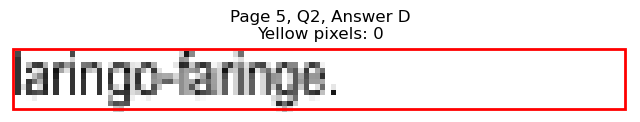


Page 5, Q2 - Selected Answer: C (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=217.4, x1=115.0, y1=228.4
Page 5, Q3, A: Yellow pixels: 97
Page 5, Q3, A: Total non-white pixels: 344
Page 5, Q3, A: Yellow percentage: 28.2%


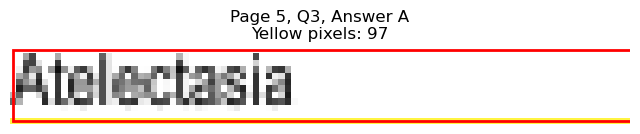

Page 5, Q3 - B: Detected box: x0=68.3, y0=230.0, x1=142.6, y1=241.0
Page 5, Q3, B: Yellow pixels: 1230
Page 5, Q3, B: Total non-white pixels: 1502
Page 5, Q3, B: Yellow percentage: 81.9%


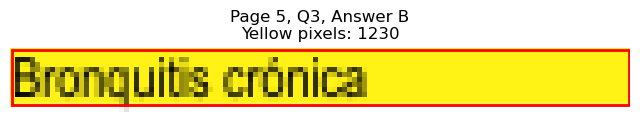

Page 5, Q3 - C: Detected box: x0=327.5, y0=217.4, x1=367.6, y1=228.4
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 198
Page 5, Q3, C: Yellow percentage: 0.0%


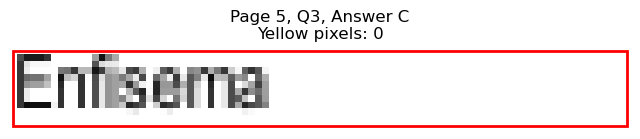

Page 5, Q3 - D: Detected box: x0=327.5, y0=230.0, x1=371.6, y1=241.0
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 223
Page 5, Q3, D: Yellow percentage: 0.0%


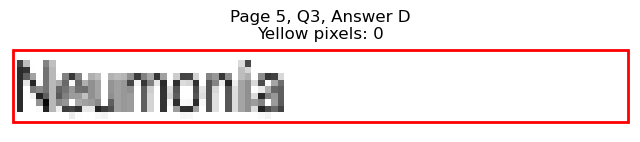


Page 5, Q3 - Selected Answer: B (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=293.1, x1=149.0, y1=304.2
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 429
Page 5, Q4, A: Yellow percentage: 0.0%


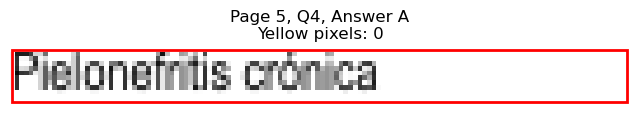

Page 5, Q4 - B: Detected box: x0=68.3, y0=305.7, x1=121.9, y1=316.8
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 264
Page 5, Q4, B: Yellow percentage: 0.0%


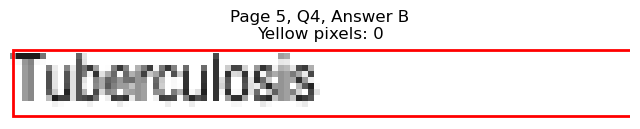

Page 5, Q4 - C: Detected box: x0=327.5, y0=293.1, x1=412.2, y1=304.2
Page 5, Q4, C: Yellow pixels: 136
Page 5, Q4, C: Total non-white pixels: 719
Page 5, Q4, C: Yellow percentage: 18.9%


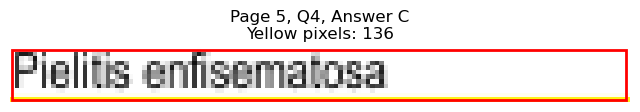

Page 5, Q4 - D: Detected box: x0=327.5, y0=305.7, x1=394.7, y1=316.8
Page 5, Q4, D: Yellow pixels: 1161
Page 5, Q4, D: Total non-white pixels: 1416
Page 5, Q4, D: Yellow percentage: 82.0%


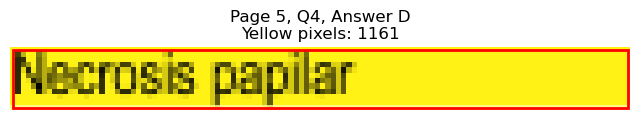


Page 5, Q4 - Selected Answer: D (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=356.2, x1=86.9, y1=367.3
Page 5, Q5, A: Yellow pixels: 691
Page 5, Q5, A: Total non-white pixels: 828
Page 5, Q5, A: Yellow percentage: 83.5%


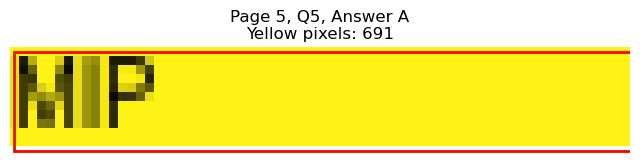

Page 5, Q5 - B: Detected box: x0=68.3, y0=368.8, x1=91.3, y1=379.9
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 115
Page 5, Q5, B: Yellow percentage: 0.0%


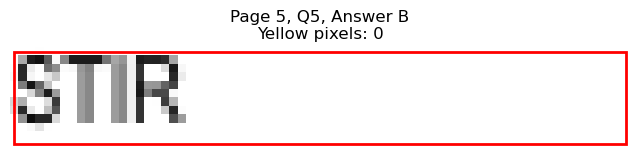

Page 5, Q5 - C: Detected box: x0=327.5, y0=356.2, x1=349.1, y1=367.3
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 101
Page 5, Q5, C: Yellow percentage: 0.0%


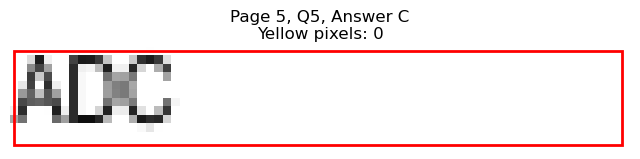

Page 5, Q5 - D: Detected box: x0=327.5, y0=368.8, x1=362.6, y1=379.9
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 184
Page 5, Q5, D: Yellow percentage: 0.0%


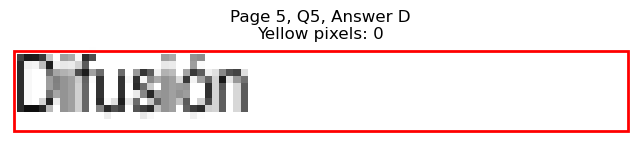


Page 5, Q5 - Selected Answer: A (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=419.4, x1=136.0, y1=430.4
Page 5, Q6, A: Yellow pixels: 1044
Page 5, Q6, A: Total non-white pixels: 1416
Page 5, Q6, A: Yellow percentage: 73.7%


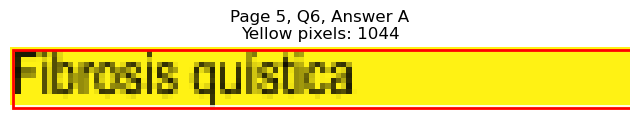

Page 5, Q6 - B: Detected box: x0=68.3, y0=432.0, x1=138.5, y1=443.0
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 374
Page 5, Q6, B: Yellow percentage: 0.0%


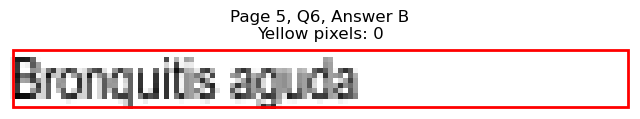

Page 5, Q6 - C: Detected box: x0=327.5, y0=419.4, x1=407.3, y1=430.4
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 404
Page 5, Q6, C: Yellow percentage: 0.0%


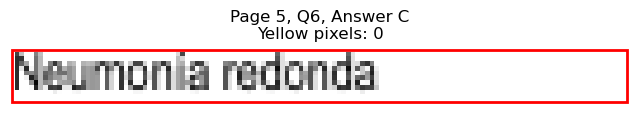

Page 5, Q6 - D: Detected box: x0=327.5, y0=432.0, x1=392.6, y1=443.0
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 327
Page 5, Q6, D: Yellow percentage: 0.0%


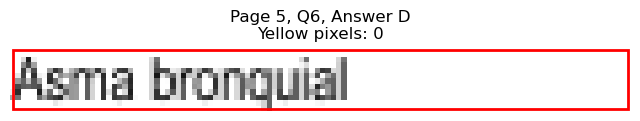


Page 5, Q6 - Selected Answer: A (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=469.8, x1=121.9, y1=480.8
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 237
Page 5, Q7, A: Yellow percentage: 0.0%


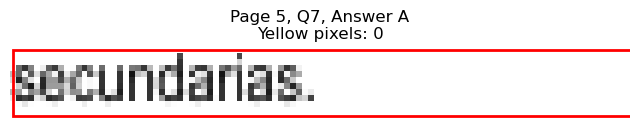

Page 5, Q7 - B: Detected box: x0=68.3, y0=482.5, x1=122.4, y1=493.5
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 288
Page 5, Q7, B: Yellow percentage: 0.0%


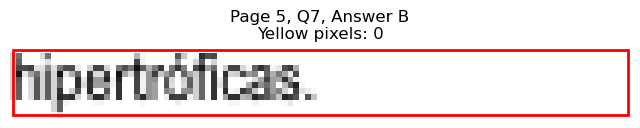

Page 5, Q7 - C: Detected box: x0=327.5, y0=469.8, x1=366.1, y1=480.8
Page 5, Q7, C: Yellow pixels: 947
Page 5, Q7, C: Total non-white pixels: 1080
Page 5, Q7, C: Yellow percentage: 87.7%


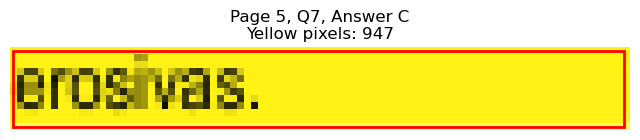

Page 5, Q7 - D: Detected box: x0=327.5, y0=482.5, x1=377.2, y1=493.5
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 237
Page 5, Q7, D: Yellow percentage: 0.0%


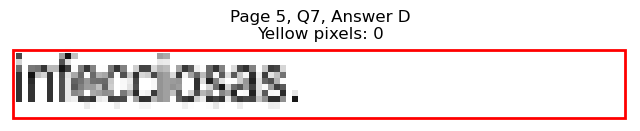


Page 5, Q7 - Selected Answer: C (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=520.3, x1=137.5, y1=531.3
Page 5, Q8, A: Yellow pixels: 120
Page 5, Q8, A: Total non-white pixels: 485
Page 5, Q8, A: Yellow percentage: 24.7%


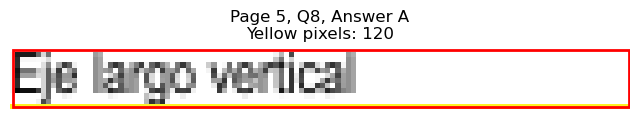

Page 5, Q8 - B: Detected box: x0=68.3, y0=532.9, x1=126.0, y1=543.9
Page 5, Q8, B: Yellow pixels: 1076
Page 5, Q8, B: Total non-white pixels: 1296
Page 5, Q8, B: Yellow percentage: 83.0%


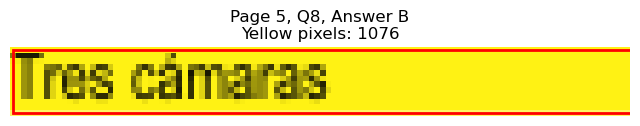

Page 5, Q8 - C: Detected box: x0=327.5, y0=520.3, x1=407.3, y1=531.3
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 406
Page 5, Q8, C: Yellow percentage: 0.0%


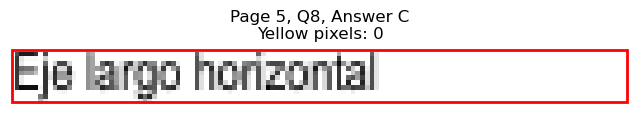

Page 5, Q8 - D: Detected box: x0=327.5, y0=532.9, x1=365.6, y1=543.9
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 179
Page 5, Q8, D: Yellow percentage: 0.0%


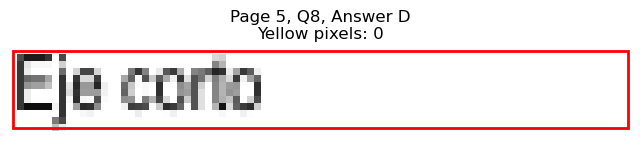


Page 5, Q8 - Selected Answer: B (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=570.8, x1=171.6, y1=581.8
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 507
Page 5, Q9, A: Yellow percentage: 0.0%


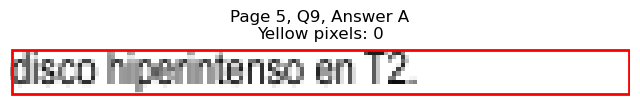

Page 5, Q9 - B: Detected box: x0=68.3, y0=583.4, x1=207.7, y1=594.4
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 715
Page 5, Q9, B: Yellow percentage: 0.0%


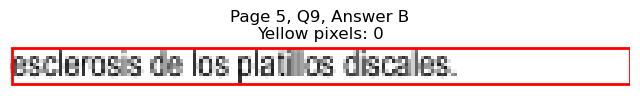

Page 5, Q9 - C: Detected box: x0=327.5, y0=570.8, x1=417.7, y1=581.8
Page 5, Q9, C: Yellow pixels: 3
Page 5, Q9, C: Total non-white pixels: 623
Page 5, Q9, C: Yellow percentage: 0.5%


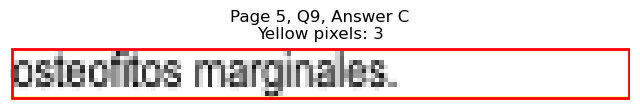

Page 5, Q9 - D: Detected box: x0=327.5, y0=583.4, x1=427.8, y1=594.4
Page 5, Q9, D: Yellow pixels: 1319
Page 5, Q9, D: Total non-white pixels: 1812
Page 5, Q9, D: Yellow percentage: 72.8%


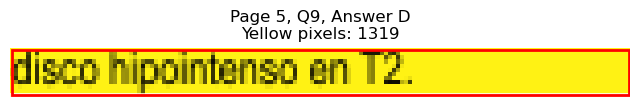


Page 5, Q9 - Selected Answer: D (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=68.3, y0=646.5, x1=142.0, y1=657.6
Page 5, Q10, A: Yellow pixels: 0
Page 5, Q10, A: Total non-white pixels: 357
Page 5, Q10, A: Yellow percentage: 0.0%


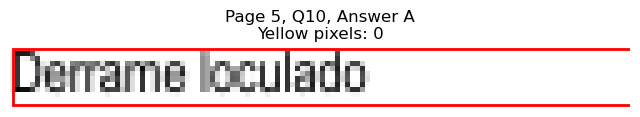

Page 5, Q10 - B: Detected box: x0=68.3, y0=659.1, x1=136.9, y1=670.2
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 337
Page 5, Q10, B: Yellow percentage: 0.0%


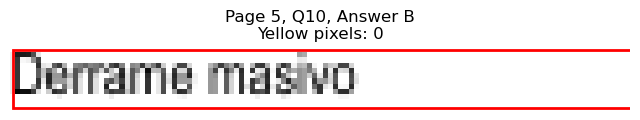

Page 5, Q10 - C: Detected box: x0=327.5, y0=646.5, x1=393.1, y1=657.6
Page 5, Q10, C: Yellow pixels: 117
Page 5, Q10, C: Total non-white pixels: 463
Page 5, Q10, C: Yellow percentage: 25.3%


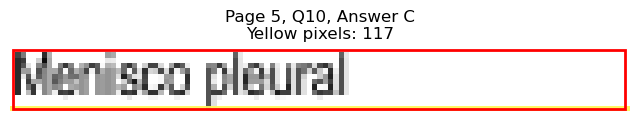

Page 5, Q10 - D: Detected box: x0=327.5, y0=659.1, x1=419.8, y1=670.2
Page 5, Q10, D: Yellow pixels: 1231
Page 5, Q10, D: Total non-white pixels: 1575
Page 5, Q10, D: Yellow percentage: 78.2%


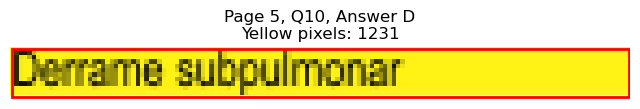


Page 5, Q10 - Selected Answer: D (based on yellow pixel count)




Page 5, Q11 - A: Detected box: x0=68.3, y0=709.6, x1=126.5, y1=720.7
Page 5, Q11, A: Yellow pixels: 1073
Page 5, Q11, A: Total non-white pixels: 1308
Page 5, Q11, A: Yellow percentage: 82.0%


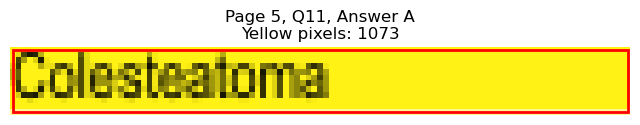

Page 5, Q11 - B: Detected box: x0=68.3, y0=722.2, x1=123.0, y1=733.3
Page 5, Q11, B: Yellow pixels: 0
Page 5, Q11, B: Total non-white pixels: 278
Page 5, Q11, B: Yellow percentage: 0.0%


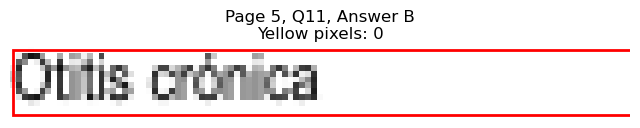

Page 5, Q11 - C: Detected box: x0=327.5, y0=709.6, x1=402.2, y1=720.7
Page 5, Q11, C: Yellow pixels: 0
Page 5, Q11, C: Total non-white pixels: 374
Page 5, Q11, C: Yellow percentage: 0.0%


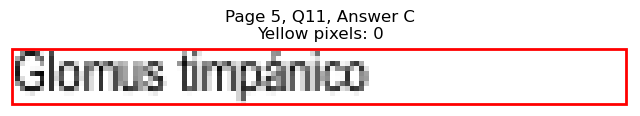

Page 5, Q11 - D: Detected box: x0=327.5, y0=722.2, x1=378.1, y1=733.3
Page 5, Q11, D: Yellow pixels: 0
Page 5, Q11, D: Total non-white pixels: 277
Page 5, Q11, D: Yellow percentage: 0.0%


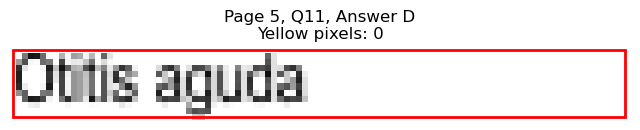


Page 5, Q11 - Selected Answer: A (based on yellow pixel count)





Page 6: Found 11 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=121.0, y1=114.8
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 253
Page 6, Q1, A: Yellow percentage: 0.0%


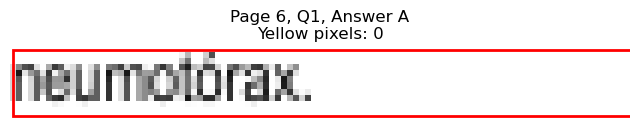

Page 6, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=159.1, y1=127.4
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 455
Page 6, Q1, B: Yellow percentage: 0.0%


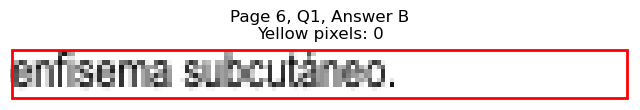

Page 6, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=403.7, y1=114.8
Page 6, Q1, C: Yellow pixels: 1260
Page 6, Q1, C: Total non-white pixels: 1524
Page 6, Q1, C: Yellow percentage: 82.7%


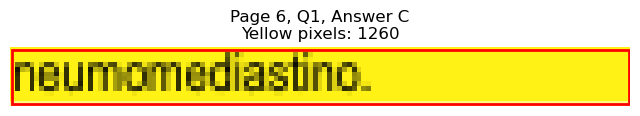

Page 6, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=372.6, y1=127.4
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 207
Page 6, Q1, D: Yellow percentage: 0.0%


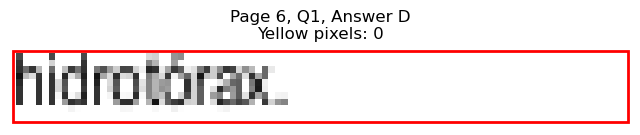


Page 6, Q1 - Selected Answer: C (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=154.3, x1=126.5, y1=165.3
Page 6, Q2, A: Yellow pixels: 109
Page 6, Q2, A: Total non-white pixels: 418
Page 6, Q2, A: Yellow percentage: 26.1%


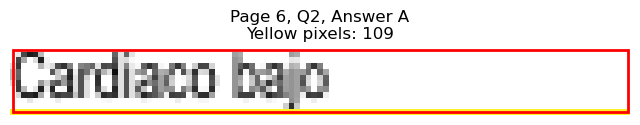

Page 6, Q2 - B: Detected box: x0=68.3, y0=166.9, x1=124.0, y1=177.9
Page 6, Q2, B: Yellow pixels: 1061
Page 6, Q2, B: Total non-white pixels: 1272
Page 6, Q2, B: Yellow percentage: 83.4%


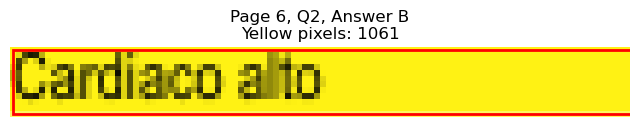

Page 6, Q2 - C: Detected box: x0=327.5, y0=154.3, x1=404.8, y1=165.3
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 386
Page 6, Q2, C: Yellow percentage: 0.0%


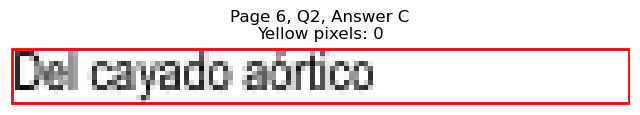

Page 6, Q2 - D: Detected box: x0=327.5, y0=166.9, x1=424.3, y1=177.9
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 490
Page 6, Q2, D: Yellow percentage: 0.0%


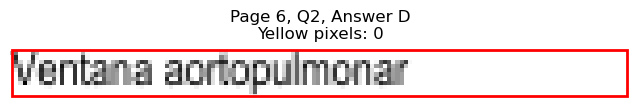


Page 6, Q2 - Selected Answer: B (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=217.4, x1=154.1, y1=228.4
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 380
Page 6, Q3, A: Yellow percentage: 0.0%


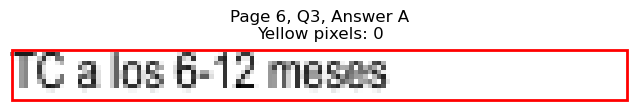

Page 6, Q3 - B: Detected box: x0=68.3, y0=230.0, x1=149.0, y1=241.0
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 369
Page 6, Q3, B: Yellow percentage: 0.0%


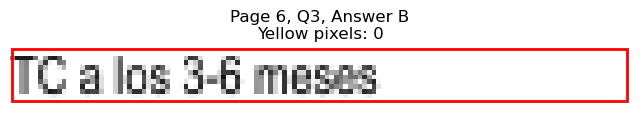

Page 6, Q3 - C: Detected box: x0=327.5, y0=217.4, x1=428.3, y1=228.4
Page 6, Q3, C: Yellow pixels: 1310
Page 6, Q3, C: Total non-white pixels: 1824
Page 6, Q3, C: Yellow percentage: 71.8%


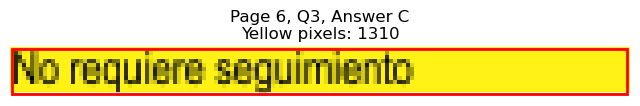

Page 6, Q3 - D: Detected box: x0=327.5, y0=230.0, x1=362.0, y1=241.0
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 142
Page 6, Q3, D: Yellow percentage: 0.0%


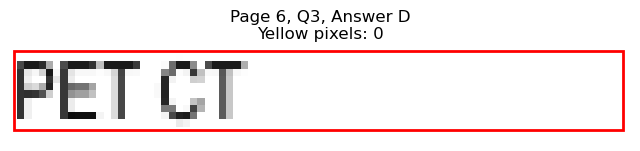


Page 6, Q3 - Selected Answer: C (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=280.5, x1=169.6, y1=291.6
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 498
Page 6, Q4, A: Yellow percentage: 0.0%


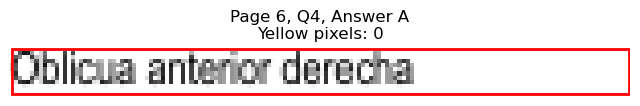

Page 6, Q4 - B: Detected box: x0=68.3, y0=293.1, x1=135.0, y1=304.2
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 331
Page 6, Q4, B: Yellow percentage: 0.0%


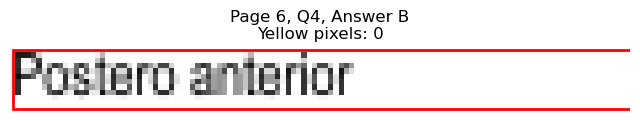

Page 6, Q4 - C: Detected box: x0=327.5, y0=280.5, x1=392.6, y1=291.6
Page 6, Q4, C: Yellow pixels: 116
Page 6, Q4, C: Total non-white pixels: 438
Page 6, Q4, C: Yellow percentage: 26.5%


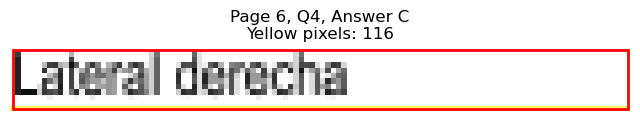

Page 6, Q4 - D: Detected box: x0=327.5, y0=293.1, x1=394.2, y1=304.2
Page 6, Q4, D: Yellow pixels: 1050
Page 6, Q4, D: Total non-white pixels: 1300
Page 6, Q4, D: Yellow percentage: 80.8%


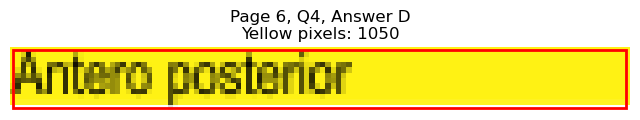


Page 6, Q4 - Selected Answer: D (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=343.6, x1=124.9, y1=354.7
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 275
Page 6, Q5, A: Yellow percentage: 0.0%


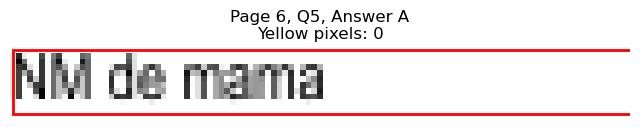

Page 6, Q5 - B: Detected box: x0=68.3, y0=356.2, x1=132.5, y1=367.3
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 336
Page 6, Q5, B: Yellow percentage: 0.0%


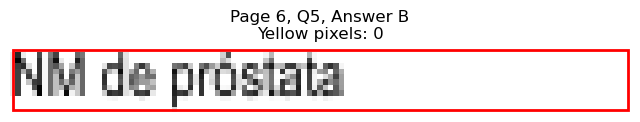

Page 6, Q5 - C: Detected box: x0=327.5, y0=343.6, x1=430.3, y1=354.7
Page 6, Q5, C: Yellow pixels: 154
Page 6, Q5, C: Total non-white pixels: 660
Page 6, Q5, C: Yellow percentage: 23.3%


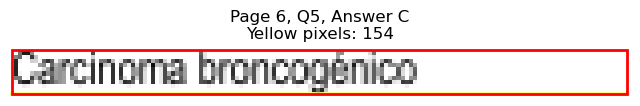

Page 6, Q5 - D: Detected box: x0=327.5, y0=356.2, x1=397.7, y1=367.3
Page 6, Q5, D: Yellow pixels: 1032
Page 6, Q5, D: Total non-white pixels: 1452
Page 6, Q5, D: Yellow percentage: 71.1%


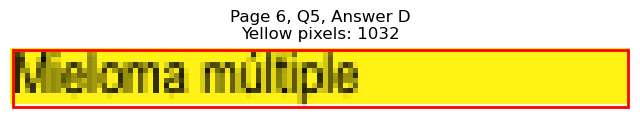


Page 6, Q5 - Selected Answer: D (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=406.6, x1=115.0, y1=417.7
Page 6, Q6, A: Yellow pixels: 992
Page 6, Q6, A: Total non-white pixels: 1164
Page 6, Q6, A: Yellow percentage: 85.2%


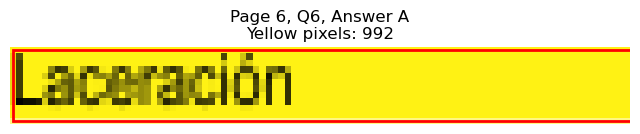

Page 6, Q6 - B: Detected box: x0=68.3, y0=419.4, x1=111.4, y1=430.4
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 224
Page 6, Q6, B: Yellow percentage: 0.0%


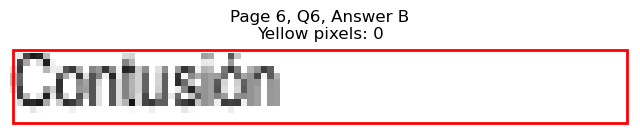

Page 6, Q6 - C: Detected box: x0=327.5, y0=406.6, x1=458.8, y1=417.7
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 685
Page 6, Q6, C: Yellow percentage: 0.0%


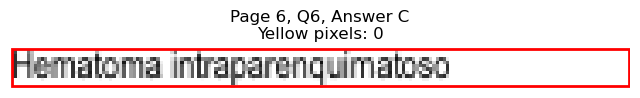

Page 6, Q6 - D: Detected box: x0=327.5, y0=419.4, x1=425.3, y1=430.4
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 509
Page 6, Q6, D: Yellow percentage: 0.0%


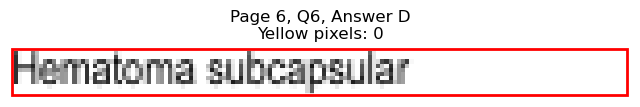


Page 6, Q6 - Selected Answer: A (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=457.2, x1=132.5, y1=468.2
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 286
Page 6, Q7, A: Yellow percentage: 0.0%


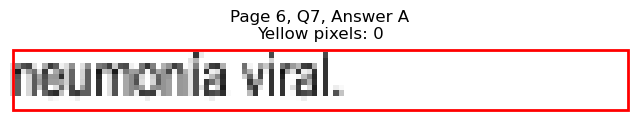

Page 6, Q7 - B: Detected box: x0=68.3, y0=469.8, x1=158.0, y1=480.8
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 455
Page 6, Q7, B: Yellow percentage: 0.0%


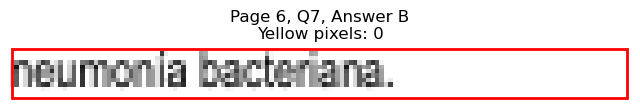

Page 6, Q7 - C: Detected box: x0=327.5, y0=457.2, x1=413.3, y1=468.2
Page 6, Q7, C: Yellow pixels: 1201
Page 6, Q7, C: Total non-white pixels: 1507
Page 6, Q7, C: Yellow percentage: 79.7%


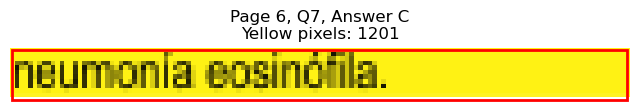

Page 6, Q7 - D: Detected box: x0=327.5, y0=469.8, x1=453.8, y1=480.8
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 635
Page 6, Q7, D: Yellow percentage: 0.0%


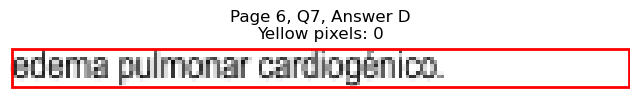


Page 6, Q7 - Selected Answer: C (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=507.7, x1=136.0, y1=518.7
Page 6, Q8, A: Yellow pixels: 1168
Page 6, Q8, A: Total non-white pixels: 1416
Page 6, Q8, A: Yellow percentage: 82.5%


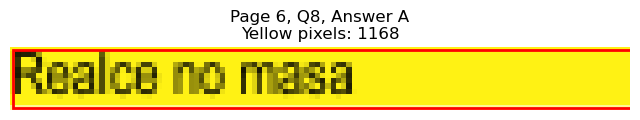

Page 6, Q8 - B: Detected box: x0=68.3, y0=520.3, x1=90.8, y1=531.3
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 94
Page 6, Q8, B: Yellow percentage: 0.0%


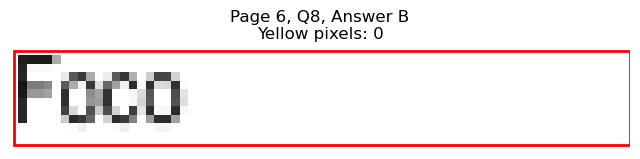

Page 6, Q8 - C: Detected box: x0=327.5, y0=507.7, x1=410.2, y1=518.7
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 452
Page 6, Q8, C: Yellow percentage: 0.0%


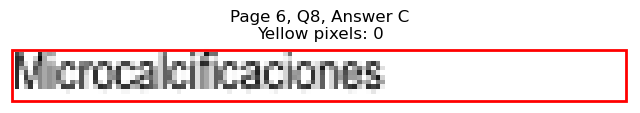

Page 6, Q8 - D: Detected box: x0=327.5, y0=520.3, x1=399.7, y1=531.3
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 357
Page 6, Q8, D: Yellow percentage: 0.0%


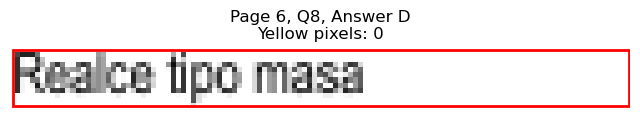


Page 6, Q8 - Selected Answer: A (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=570.8, x1=173.6, y1=581.8
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 721
Page 6, Q9, A: Yellow percentage: 0.0%


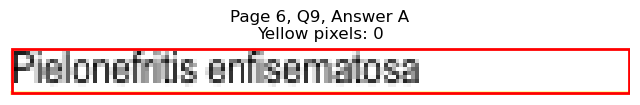

Page 6, Q9 - B: Detected box: x0=68.3, y0=583.4, x1=201.6, y1=594.4
Page 6, Q9, B: Yellow pixels: 1501
Page 6, Q9, B: Total non-white pixels: 2208
Page 6, Q9, B: Yellow percentage: 68.0%


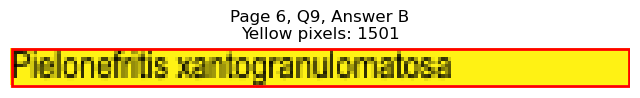

Page 6, Q9 - C: Detected box: x0=327.5, y0=570.8, x1=404.3, y1=581.8
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 407
Page 6, Q9, C: Yellow percentage: 0.0%


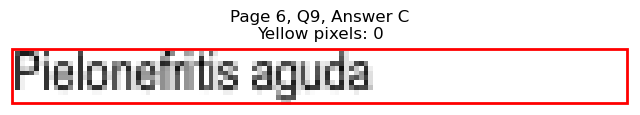

Page 6, Q9 - D: Detected box: x0=327.5, y0=583.4, x1=387.1, y1=594.4
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 294
Page 6, Q9, D: Yellow percentage: 0.0%


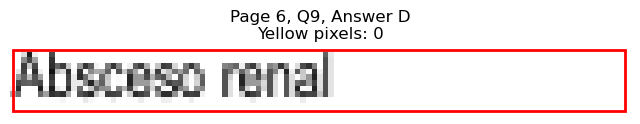


Page 6, Q9 - Selected Answer: B (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=68.3, y0=646.5, x1=122.4, y1=657.6
Page 6, Q10, A: Yellow pixels: 0
Page 6, Q10, A: Total non-white pixels: 302
Page 6, Q10, A: Yellow percentage: 0.0%


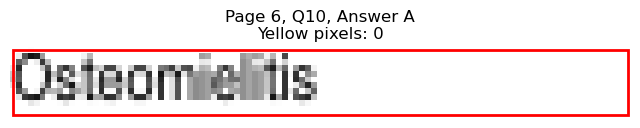

Page 6, Q10 - B: Detected box: x0=68.3, y0=659.1, x1=127.9, y1=670.2
Page 6, Q10, B: Yellow pixels: 0
Page 6, Q10, B: Total non-white pixels: 303
Page 6, Q10, B: Yellow percentage: 0.0%


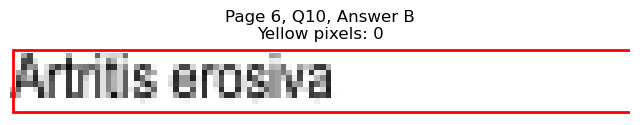

Page 6, Q10 - C: Detected box: x0=327.5, y0=646.5, x1=416.3, y1=657.6
Page 6, Q10, C: Yellow pixels: 1203
Page 6, Q10, C: Total non-white pixels: 1680
Page 6, Q10, C: Yellow percentage: 71.6%


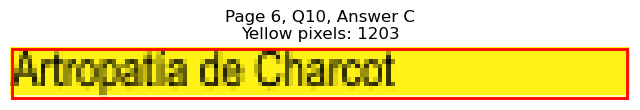

Page 6, Q10 - D: Detected box: x0=327.5, y0=659.1, x1=402.7, y1=670.2
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 389
Page 6, Q10, D: Yellow percentage: 0.0%


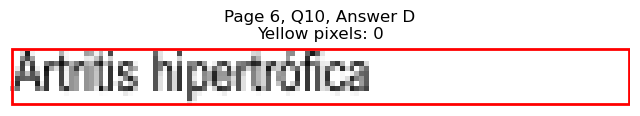


Page 6, Q10 - Selected Answer: C (based on yellow pixel count)




Page 6, Q11 - A: Detected box: x0=68.3, y0=709.6, x1=106.4, y1=720.7
Page 6, Q11, A: Yellow pixels: 0
Page 6, Q11, A: Total non-white pixels: 216
Page 6, Q11, A: Yellow percentage: 0.0%


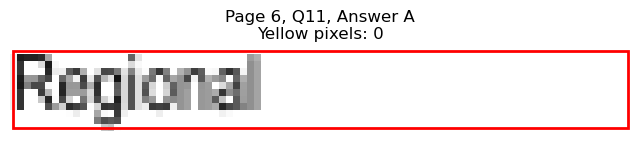

Page 6, Q11 - B: Detected box: x0=68.3, y0=722.2, x1=92.9, y1=733.3
Page 6, Q11, B: Yellow pixels: 0
Page 6, Q11, B: Total non-white pixels: 101
Page 6, Q11, B: Yellow percentage: 0.0%


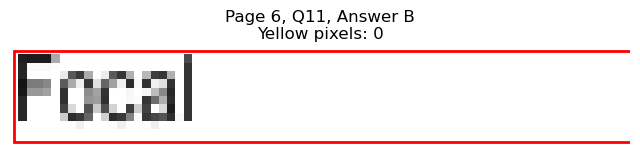

Page 6, Q11 - C: Detected box: x0=327.5, y0=709.6, x1=355.6, y1=720.7
Page 6, Q11, C: Yellow pixels: 79
Page 6, Q11, C: Total non-white pixels: 219
Page 6, Q11, C: Yellow percentage: 36.1%


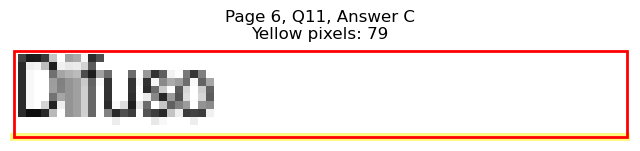

Page 6, Q11 - D: Detected box: x0=327.5, y0=722.2, x1=378.7, y1=733.3
Page 6, Q11, D: Yellow pixels: 915
Page 6, Q11, D: Total non-white pixels: 1224
Page 6, Q11, D: Yellow percentage: 74.8%


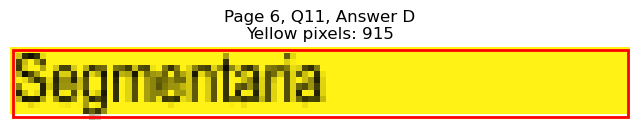


Page 6, Q11 - Selected Answer: D (based on yellow pixel count)





Page 7: Found 12 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=115.1, y1=114.8
Page 7, Q1, A: Yellow pixels: 987
Page 7, Q1, A: Total non-white pixels: 1176
Page 7, Q1, A: Yellow percentage: 83.9%


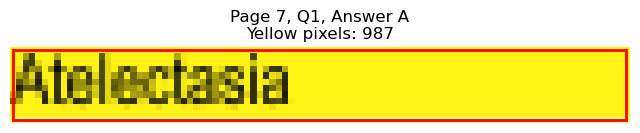

Page 7, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=137.0, y1=127.4
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 354
Page 7, Q1, B: Yellow percentage: 0.0%


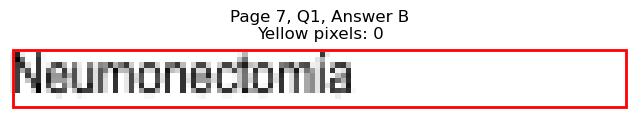

Page 7, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=394.7, y1=114.8
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 347
Page 7, Q1, C: Yellow percentage: 0.0%


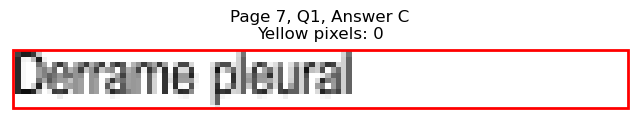

Page 7, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=371.8, y1=127.4
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 223
Page 7, Q1, D: Yellow percentage: 0.0%


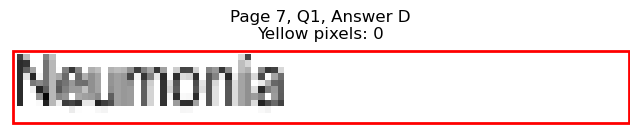


Page 7, Q1 - Selected Answer: A (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=166.9, x1=132.0, y1=177.9
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 304
Page 7, Q2, A: Yellow percentage: 0.0%


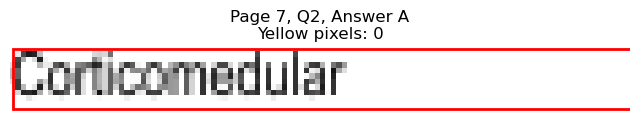

Page 7, Q2 - B: Detected box: x0=68.3, y0=179.5, x1=109.4, y1=190.5
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 205
Page 7, Q2, B: Yellow percentage: 0.0%


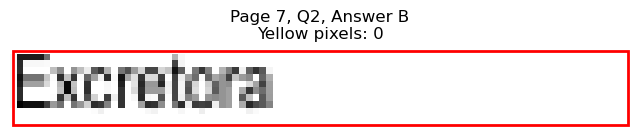

Page 7, Q2 - C: Detected box: x0=327.5, y0=166.9, x1=379.1, y1=177.9
Page 7, Q2, C: Yellow pixels: 1015
Page 7, Q2, C: Total non-white pixels: 1236
Page 7, Q2, C: Yellow percentage: 82.1%


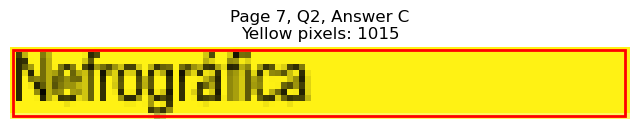

Page 7, Q2 - D: Detected box: x0=327.5, y0=179.5, x1=382.7, y1=190.5
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 267
Page 7, Q2, D: Yellow percentage: 0.0%


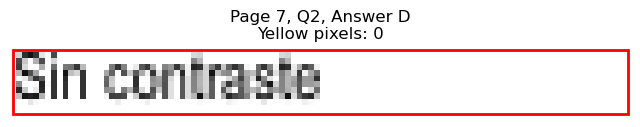


Page 7, Q2 - Selected Answer: C (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=217.4, x1=117.5, y1=228.4
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 285
Page 7, Q3, A: Yellow percentage: 0.0%


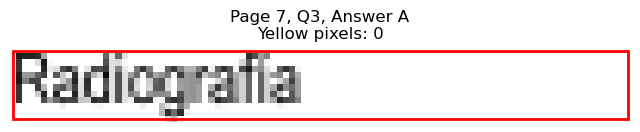

Page 7, Q3 - B: Detected box: x0=68.3, y0=230.0, x1=118.4, y1=241.0
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 243
Page 7, Q3, B: Yellow percentage: 0.0%


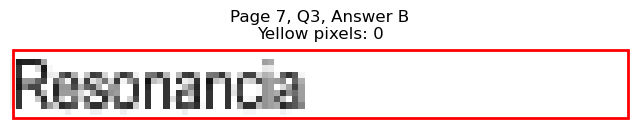

Page 7, Q3 - C: Detected box: x0=327.5, y0=217.4, x1=376.1, y1=228.4
Page 7, Q3, C: Yellow pixels: 923
Page 7, Q3, C: Total non-white pixels: 1200
Page 7, Q3, C: Yellow percentage: 76.9%


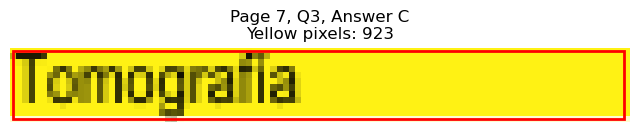

Page 7, Q3 - D: Detected box: x0=327.5, y0=671.7, x1=368.8, y1=682.8
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 505
Page 7, Q3, D: Yellow percentage: 0.0%


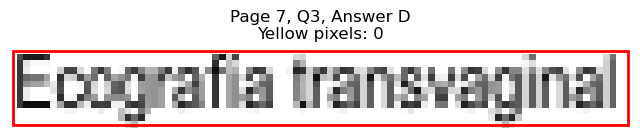


Page 7, Q3 - Selected Answer: C (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=267.8, x1=138.5, y1=278.8
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 377
Page 7, Q4, A: Yellow percentage: 0.0%


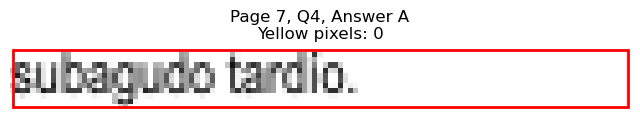

Page 7, Q4 - B: Detected box: x0=68.3, y0=280.5, x1=142.6, y1=291.6
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 376
Page 7, Q4, B: Yellow percentage: 0.0%


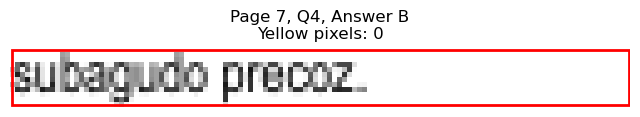

Page 7, Q4 - C: Detected box: x0=327.5, y0=267.8, x1=361.6, y1=278.8
Page 7, Q4, C: Yellow pixels: 896
Page 7, Q4, C: Total non-white pixels: 1020
Page 7, Q4, C: Yellow percentage: 87.8%


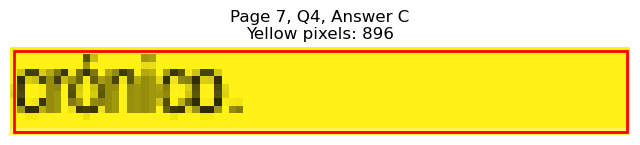

Page 7, Q4 - D: Detected box: x0=327.5, y0=280.5, x1=377.6, y1=291.6
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 243
Page 7, Q4, D: Yellow percentage: 0.0%


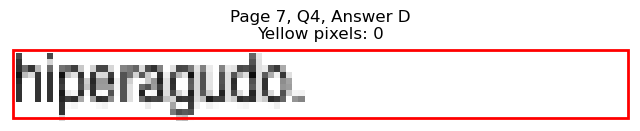


Page 7, Q4 - Selected Answer: C (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=343.6, x1=137.5, y1=354.7
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 356
Page 7, Q5, A: Yellow percentage: 0.0%


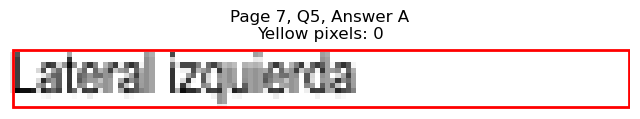

Page 7, Q5 - B: Detected box: x0=68.3, y0=356.2, x1=145.6, y1=367.3
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 414
Page 7, Q5, B: Yellow percentage: 0.0%


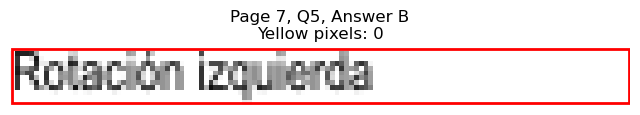

Page 7, Q5 - C: Detected box: x0=327.5, y0=343.6, x1=393.2, y1=354.7
Page 7, Q5, C: Yellow pixels: 1174
Page 7, Q5, C: Total non-white pixels: 1404
Page 7, Q5, C: Yellow percentage: 83.6%


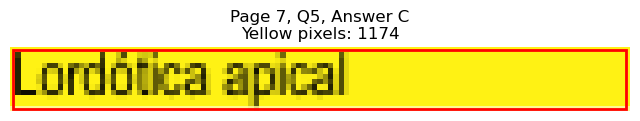

Page 7, Q5 - D: Detected box: x0=327.5, y0=356.2, x1=395.6, y1=367.3
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 340
Page 7, Q5, D: Yellow percentage: 0.0%


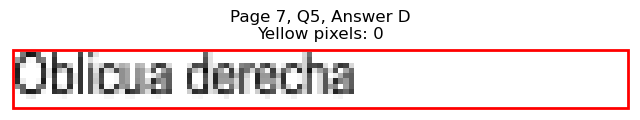


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=103.8, x1=115.1, y1=114.8
Page 7, Q6, A: Yellow pixels: 987
Page 7, Q6, A: Total non-white pixels: 1176
Page 7, Q6, A: Yellow percentage: 83.9%


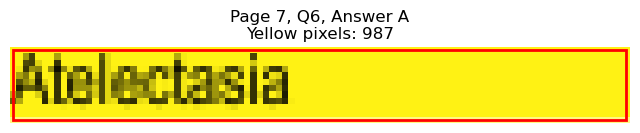

Page 7, Q6 - B: Detected box: x0=68.3, y0=406.6, x1=132.5, y1=417.7
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 334
Page 7, Q6, B: Yellow percentage: 0.0%


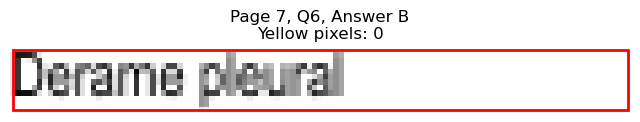

Page 7, Q6 - C: Detected box: x0=327.5, y0=394.0, x1=371.6, y1=405.1
Page 7, Q6, C: Yellow pixels: 868
Page 7, Q6, C: Total non-white pixels: 1045
Page 7, Q6, C: Yellow percentage: 83.1%


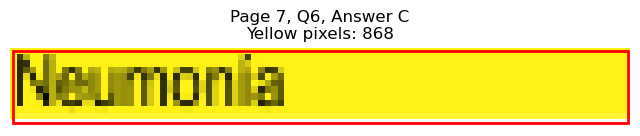

Page 7, Q6 - D: Detected box: x0=327.5, y0=406.6, x1=379.1, y1=417.7
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 267
Page 7, Q6, D: Yellow percentage: 0.0%


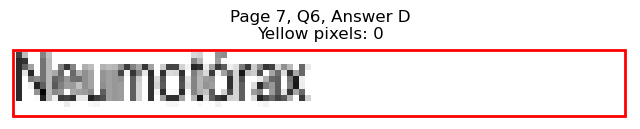


Page 7, Q6 - Selected Answer: A (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=444.6, x1=124.9, y1=455.6
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 287
Page 7, Q7, A: Yellow percentage: 0.0%


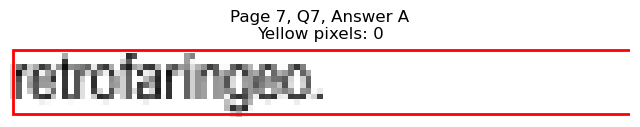

Page 7, Q7 - B: Detected box: x0=68.3, y0=457.2, x1=138.0, y1=468.2
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 358
Page 7, Q7, B: Yellow percentage: 0.0%


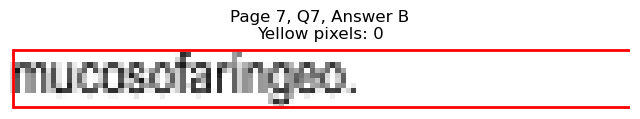

Page 7, Q7 - C: Detected box: x0=327.5, y0=444.6, x1=370.1, y1=455.6
Page 7, Q7, C: Yellow pixels: 866
Page 7, Q7, C: Total non-white pixels: 1128
Page 7, Q7, C: Yellow percentage: 76.8%


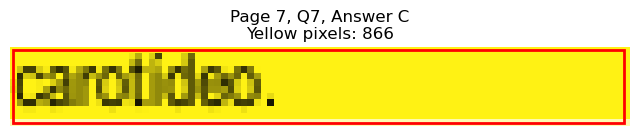

Page 7, Q7 - D: Detected box: x0=327.5, y0=457.2, x1=400.7, y1=468.2
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 361
Page 7, Q7, D: Yellow percentage: 0.0%


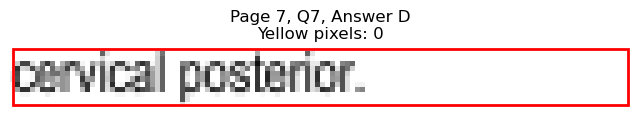


Page 7, Q7 - Selected Answer: C (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=495.1, x1=127.0, y1=506.1
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 322
Page 7, Q8, A: Yellow percentage: 0.0%


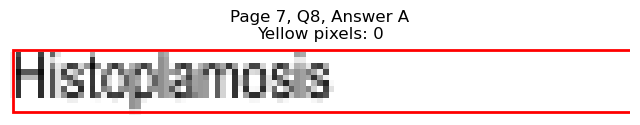

Page 7, Q8 - B: Detected box: x0=68.3, y0=507.7, x1=128.4, y1=518.7
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 302
Page 7, Q8, B: Yellow percentage: 0.0%


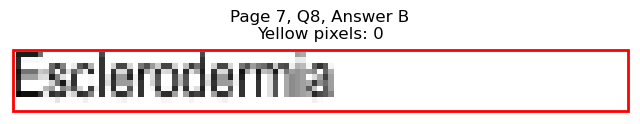

Page 7, Q8 - C: Detected box: x0=327.5, y0=495.1, x1=381.1, y1=506.1
Page 7, Q8, C: Yellow pixels: 948
Page 7, Q8, C: Total non-white pixels: 1155
Page 7, Q8, C: Yellow percentage: 82.1%


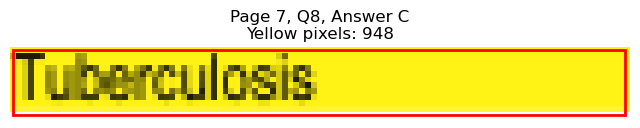

Page 7, Q8 - D: Detected box: x0=327.5, y0=507.7, x1=362.6, y1=518.7
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 173
Page 7, Q8, D: Yellow percentage: 0.0%


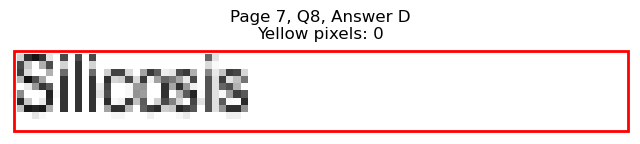


Page 7, Q8 - Selected Answer: C (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=545.5, x1=209.6, y1=556.5
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 663
Page 7, Q9, A: Yellow percentage: 0.0%


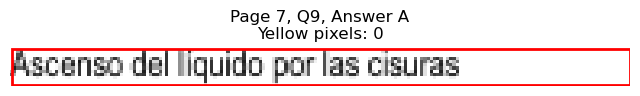

Page 7, Q9 - B: Detected box: x0=68.3, y0=558.2, x1=206.8, y1=569.2
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 693
Page 7, Q9, B: Yellow percentage: 0.0%


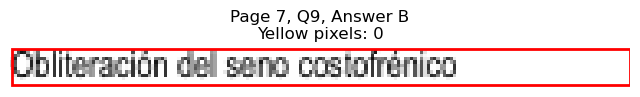

Page 7, Q9 - C: Detected box: x0=327.5, y0=545.5, x1=436.3, y1=556.5
Page 7, Q9, C: Yellow pixels: 160
Page 7, Q9, C: Total non-white pixels: 725
Page 7, Q9, C: Yellow percentage: 22.1%


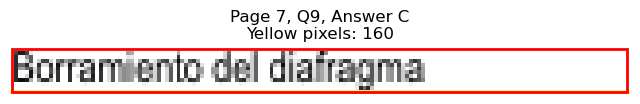

Page 7, Q9 - D: Detected box: x0=327.5, y0=558.2, x1=511.6, y1=569.2
Page 7, Q9, D: Yellow pixels: 1642
Page 7, Q9, D: Total non-white pixels: 2344
Page 7, Q9, D: Yellow percentage: 70.1%


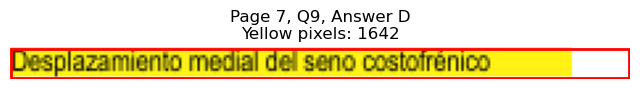


Page 7, Q9 - Selected Answer: D (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=68.3, y0=608.6, x1=130.4, y1=619.6
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 291
Page 7, Q10, A: Yellow percentage: 0.0%


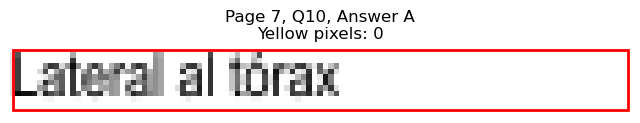

Page 7, Q10 - B: Detected box: x0=68.3, y0=621.3, x1=154.1, y1=632.4
Page 7, Q10, B: Yellow pixels: 0
Page 7, Q10, B: Total non-white pixels: 442
Page 7, Q10, B: Yellow percentage: 0.0%


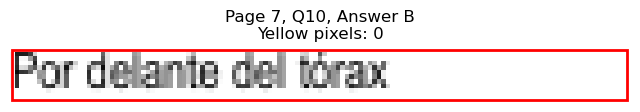

Page 7, Q10 - C: Detected box: x0=327.5, y0=608.6, x1=413.8, y1=619.6
Page 7, Q10, C: Yellow pixels: 1334
Page 7, Q10, C: Total non-white pixels: 1644
Page 7, Q10, C: Yellow percentage: 81.1%


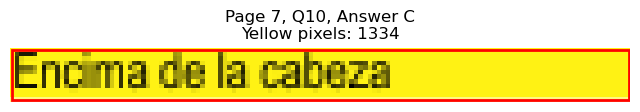

Page 7, Q10 - D: Detected box: x0=327.5, y0=621.3, x1=408.7, y1=632.4
Page 7, Q10, D: Yellow pixels: 0
Page 7, Q10, D: Total non-white pixels: 399
Page 7, Q10, D: Yellow percentage: 0.0%


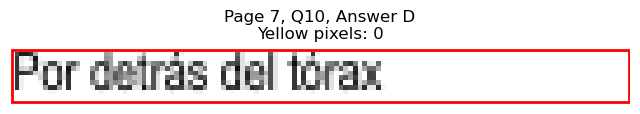


Page 7, Q10 - Selected Answer: C (based on yellow pixel count)




Page 7, Q11 - A: Detected box: x0=68.3, y0=659.1, x1=140.0, y1=670.2
Page 7, Q11, A: Yellow pixels: 0
Page 7, Q11, A: Total non-white pixels: 379
Page 7, Q11, A: Yellow percentage: 0.0%


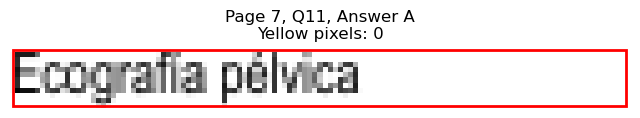

Page 7, Q11 - B: Detected box: x0=68.3, y0=671.7, x1=142.0, y1=682.8
Page 7, Q11, B: Yellow pixels: 0
Page 7, Q11, B: Total non-white pixels: 384
Page 7, Q11, B: Yellow percentage: 0.0%


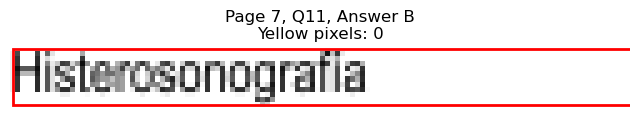

Page 7, Q11 - C: Detected box: x0=327.5, y0=659.1, x1=415.2, y1=670.2
Page 7, Q11, C: Yellow pixels: 1167
Page 7, Q11, C: Total non-white pixels: 1535
Page 7, Q11, C: Yellow percentage: 76.0%


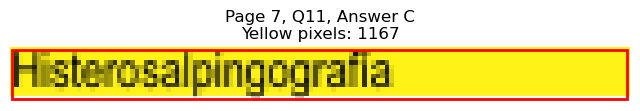

Page 7, Q11 - D: Detected box: x0=327.5, y0=671.7, x1=419.8, y1=682.8
Page 7, Q11, D: Yellow pixels: 0
Page 7, Q11, D: Total non-white pixels: 505
Page 7, Q11, D: Yellow percentage: 0.0%


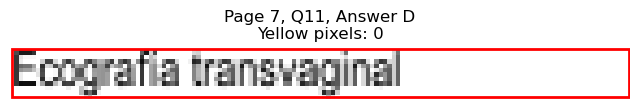


Page 7, Q11 - Selected Answer: C (based on yellow pixel count)




Page 7, Q12 - A: Detected box: x0=68.3, y0=734.8, x1=122.4, y1=745.9
Page 7, Q12, A: Yellow pixels: 0
Page 7, Q12, A: Total non-white pixels: 302
Page 7, Q12, A: Yellow percentage: 0.0%


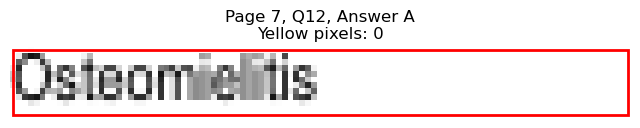

Page 7, Q12 - B: Detected box: x0=68.3, y0=747.4, x1=144.0, y1=758.5
Page 7, Q12, B: Yellow pixels: 0
Page 7, Q12, B: Total non-white pixels: 379
Page 7, Q12, B: Yellow percentage: 0.0%


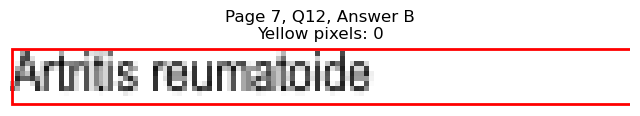

Page 7, Q12 - C: Detected box: x0=327.5, y0=734.8, x1=349.6, y1=745.9
Page 7, Q12, C: Yellow pixels: 798
Page 7, Q12, C: Total non-white pixels: 876
Page 7, Q12, C: Yellow percentage: 91.1%


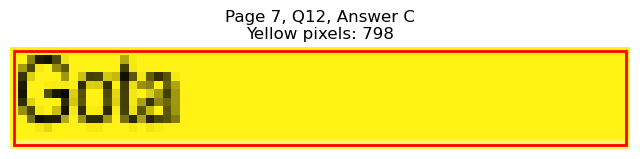

Page 7, Q12 - D: Detected box: x0=327.5, y0=747.4, x1=358.2, y1=758.5
Page 7, Q12, D: Yellow pixels: 0
Page 7, Q12, D: Total non-white pixels: 157
Page 7, Q12, D: Yellow percentage: 0.0%


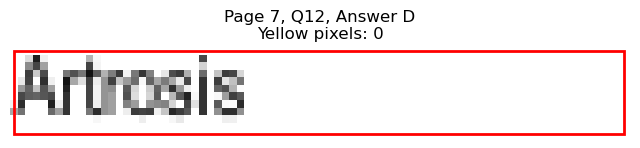


Page 7, Q12 - Selected Answer: C (based on yellow pixel count)





Page 8: Found 11 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=190.2, y1=102.2
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 602
Page 8, Q1, A: Yellow percentage: 0.0%


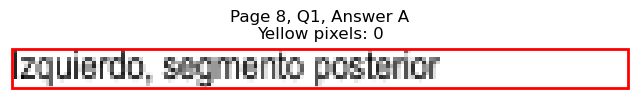

Page 8, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=182.6, y1=114.8
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 570
Page 8, Q1, B: Yellow percentage: 0.0%


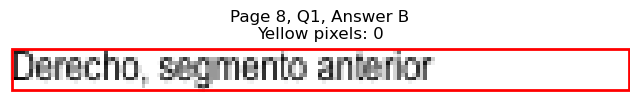

Page 8, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=444.8, y1=102.2
Page 8, Q1, C: Yellow pixels: 168
Page 8, Q1, C: Total non-white pixels: 918
Page 8, Q1, C: Yellow percentage: 18.3%


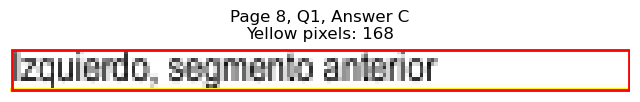

Page 8, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=446.3, y1=114.8
Page 8, Q1, D: Yellow pixels: 1565
Page 8, Q1, D: Total non-white pixels: 2040
Page 8, Q1, D: Yellow percentage: 76.7%


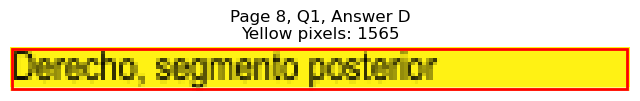


Page 8, Q1 - Selected Answer: D (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=141.7, x1=102.4, y1=152.7
Page 8, Q2, A: Yellow pixels: 85
Page 8, Q2, A: Total non-white pixels: 241
Page 8, Q2, A: Yellow percentage: 35.3%


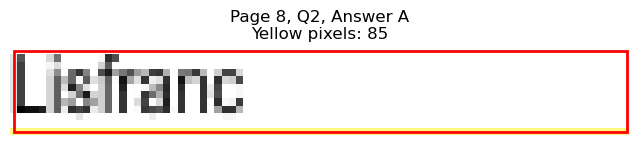

Page 8, Q2 - B: Detected box: x0=68.3, y0=154.3, x1=93.8, y1=165.3
Page 8, Q2, B: Yellow pixels: 741
Page 8, Q2, B: Total non-white pixels: 912
Page 8, Q2, B: Yellow percentage: 81.2%


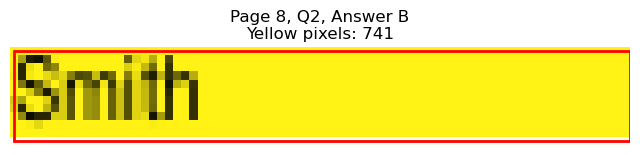

Page 8, Q2 - C: Detected box: x0=327.5, y0=141.7, x1=355.1, y1=152.7
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 145
Page 8, Q2, C: Yellow percentage: 0.0%


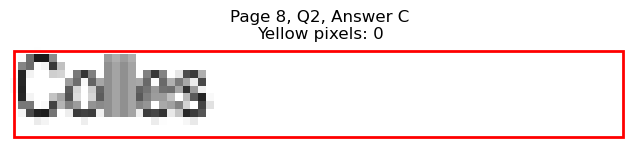

Page 8, Q2 - D: Detected box: x0=327.5, y0=154.3, x1=354.1, y1=165.3
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 128
Page 8, Q2, D: Yellow percentage: 0.0%


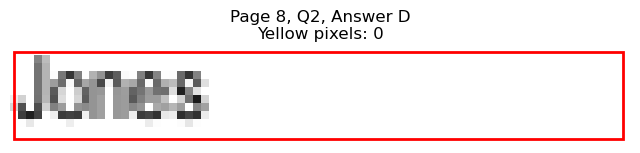


Page 8, Q2 - Selected Answer: B (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=217.4, x1=114.5, y1=228.4
Page 8, Q3, A: Yellow pixels: 897
Page 8, Q3, A: Total non-white pixels: 1164
Page 8, Q3, A: Yellow percentage: 77.1%


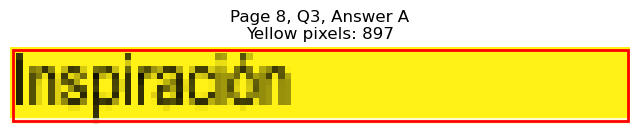

Page 8, Q3 - B: Detected box: x0=68.3, y0=230.0, x1=118.9, y1=241.0
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 258
Page 8, Q3, B: Yellow percentage: 0.0%


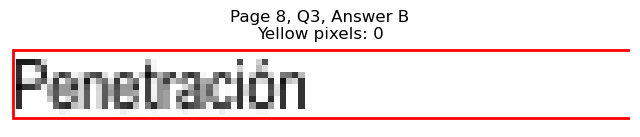

Page 8, Q3 - C: Detected box: x0=327.5, y0=217.4, x1=367.1, y1=228.4
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 193
Page 8, Q3, C: Yellow percentage: 0.0%


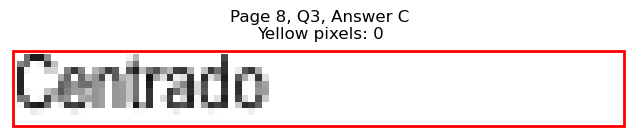

Page 8, Q3 - D: Detected box: x0=327.5, y0=230.0, x1=374.6, y1=241.0
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 223
Page 8, Q3, D: Yellow percentage: 0.0%


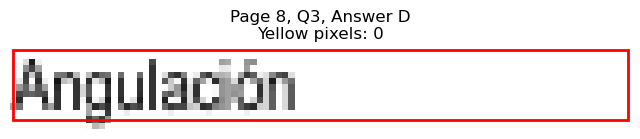


Page 8, Q3 - Selected Answer: A (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=267.8, x1=94.3, y1=278.8
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 124
Page 8, Q4, A: Yellow percentage: 0.0%


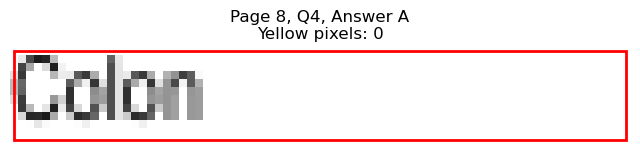

Page 8, Q4 - B: Detected box: x0=68.3, y0=280.5, x1=109.0, y1=291.6
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 213
Page 8, Q4, B: Yellow percentage: 0.0%


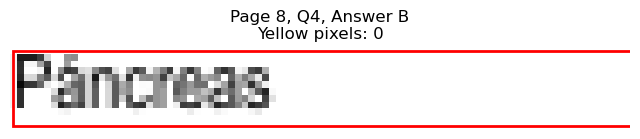

Page 8, Q4 - C: Detected box: x0=327.5, y0=267.8, x1=355.1, y1=278.8
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 215
Page 8, Q4, C: Yellow percentage: 0.0%


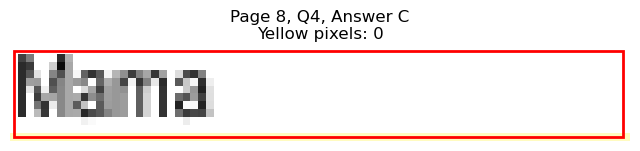

Page 8, Q4 - D: Detected box: x0=327.5, y0=280.5, x1=372.1, y1=291.6
Page 8, Q4, D: Yellow pixels: 868
Page 8, Q4, D: Total non-white pixels: 1152
Page 8, Q4, D: Yellow percentage: 75.3%


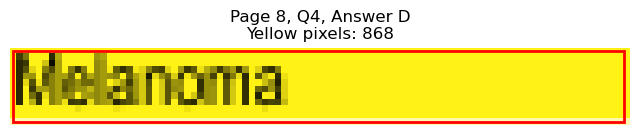


Page 8, Q4 - Selected Answer: D (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=330.9, x1=141.5, y1=342.0
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 402
Page 8, Q5, A: Yellow percentage: 0.0%


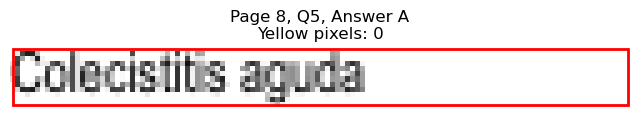

Page 8, Q5 - B: Detected box: x0=68.3, y0=343.6, x1=117.5, y1=354.7
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 260
Page 8, Q5, B: Yellow percentage: 0.0%


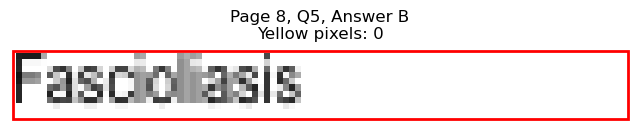

Page 8, Q5 - C: Detected box: x0=327.5, y0=330.9, x1=417.7, y1=342.0
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 593
Page 8, Q5, C: Yellow percentage: 0.0%


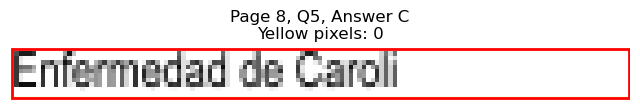

Page 8, Q5 - D: Detected box: x0=327.5, y0=343.6, x1=414.2, y1=354.7
Page 8, Q5, D: Yellow pixels: 1312
Page 8, Q5, D: Total non-white pixels: 1656
Page 8, Q5, D: Yellow percentage: 79.2%


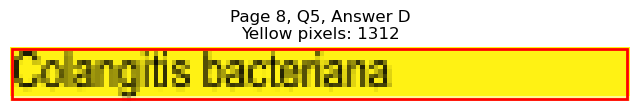


Page 8, Q5 - Selected Answer: D (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=406.6, x1=139.6, y1=417.7
Page 8, Q6, A: Yellow pixels: 1178
Page 8, Q6, A: Total non-white pixels: 1464
Page 8, Q6, A: Yellow percentage: 80.5%


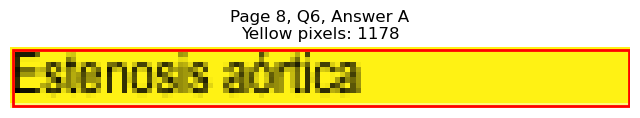

Page 8, Q6 - B: Detected box: x0=68.3, y0=419.4, x1=150.0, y1=430.4
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 404
Page 8, Q6, B: Yellow percentage: 0.0%


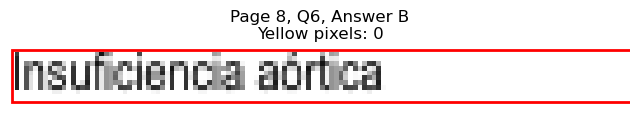

Page 8, Q6 - C: Detected box: x0=327.5, y0=406.6, x1=420.7, y1=417.7
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 496
Page 8, Q6, C: Yellow percentage: 0.0%


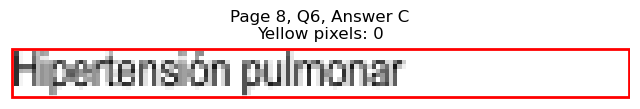

Page 8, Q6 - D: Detected box: x0=327.5, y0=419.4, x1=393.7, y1=430.4
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 339
Page 8, Q6, D: Yellow percentage: 0.0%


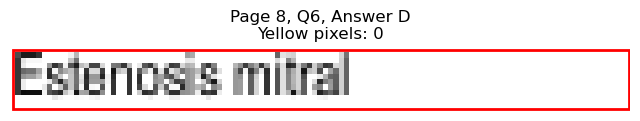


Page 8, Q6 - Selected Answer: A (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=482.5, x1=121.9, y1=493.5
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 264
Page 8, Q7, A: Yellow percentage: 0.0%


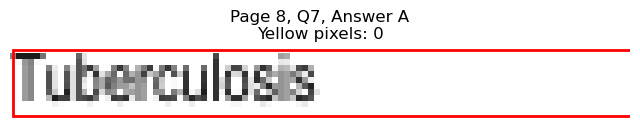

Page 8, Q7 - B: Detected box: x0=68.3, y0=495.1, x1=195.7, y1=506.1
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 659
Page 8, Q7, B: Yellow percentage: 0.0%


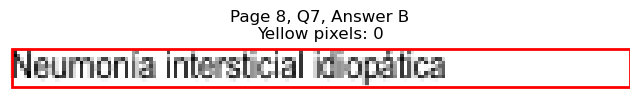

Page 8, Q7 - C: Detected box: x0=327.5, y0=482.5, x1=437.8, y1=493.5
Page 8, Q7, C: Yellow pixels: 161
Page 8, Q7, C: Total non-white pixels: 726
Page 8, Q7, C: Yellow percentage: 22.2%


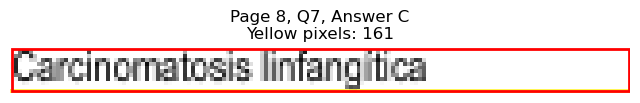

Page 8, Q7 - D: Detected box: x0=327.5, y0=495.1, x1=438.4, y1=506.1
Page 8, Q7, D: Yellow pixels: 1348
Page 8, Q7, D: Total non-white pixels: 1782
Page 8, Q7, D: Yellow percentage: 75.6%


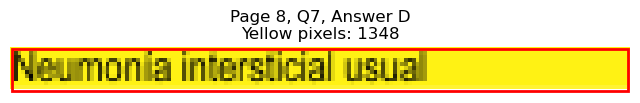


Page 8, Q7 - Selected Answer: D (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=532.9, x1=150.0, y1=543.9
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 419
Page 8, Q8, A: Yellow percentage: 0.0%


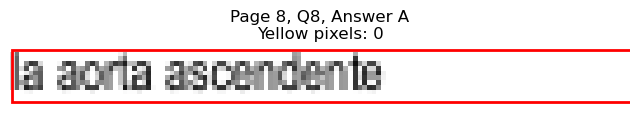

Page 8, Q8 - B: Detected box: x0=68.3, y0=545.5, x1=147.5, y1=556.5
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 404
Page 8, Q8, B: Yellow percentage: 0.0%


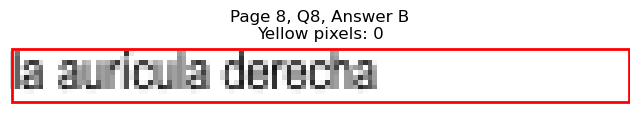

Page 8, Q8 - C: Detected box: x0=327.5, y0=532.9, x1=410.8, y1=543.9
Page 8, Q8, C: Yellow pixels: 1290
Page 8, Q8, C: Total non-white pixels: 1608
Page 8, Q8, C: Yellow percentage: 80.2%


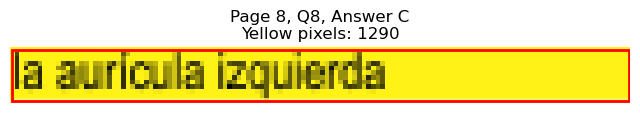

Page 8, Q8 - D: Detected box: x0=327.5, y0=545.5, x1=417.7, y1=556.5
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 452
Page 8, Q8, D: Yellow percentage: 0.0%


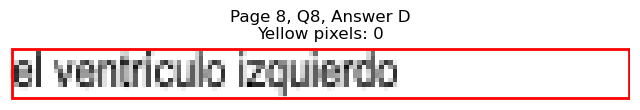


Page 8, Q8 - Selected Answer: C (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=583.4, x1=148.1, y1=594.4
Page 8, Q9, A: Yellow pixels: 131
Page 8, Q9, A: Total non-white pixels: 534
Page 8, Q9, A: Yellow percentage: 24.5%


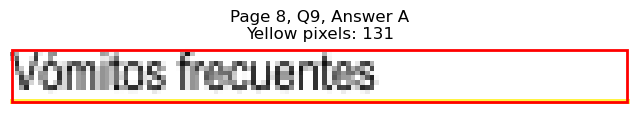

Page 8, Q9 - B: Detected box: x0=68.3, y0=596.0, x1=217.7, y1=607.0
Page 8, Q9, B: Yellow pixels: 1838
Page 8, Q9, B: Total non-white pixels: 2403
Page 8, Q9, B: Yellow percentage: 76.5%


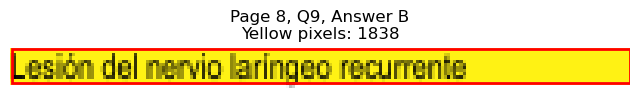

Page 8, Q9 - C: Detected box: x0=327.5, y0=583.4, x1=383.2, y1=594.4
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 278
Page 8, Q9, C: Yellow percentage: 0.0%


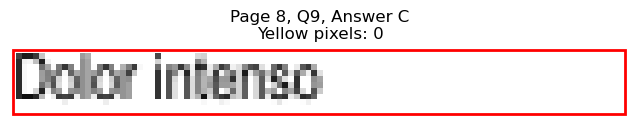

Page 8, Q9 - D: Detected box: x0=327.5, y0=596.0, x1=416.3, y1=607.0
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 441
Page 8, Q9, D: Yellow percentage: 0.0%


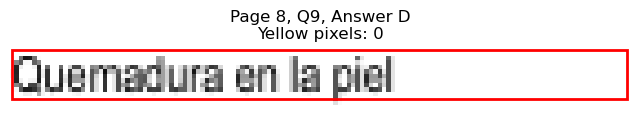


Page 8, Q9 - Selected Answer: B (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=68.3, y0=659.1, x1=109.4, y1=670.2
Page 8, Q10, A: Yellow pixels: 0
Page 8, Q10, A: Total non-white pixels: 244
Page 8, Q10, A: Yellow percentage: 0.0%


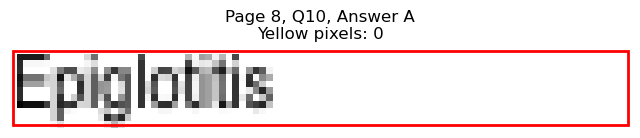

Page 8, Q10 - B: Detected box: x0=68.3, y0=671.7, x1=107.4, y1=682.8
Page 8, Q10, B: Yellow pixels: 0
Page 8, Q10, B: Total non-white pixels: 213
Page 8, Q10, B: Yellow percentage: 0.0%


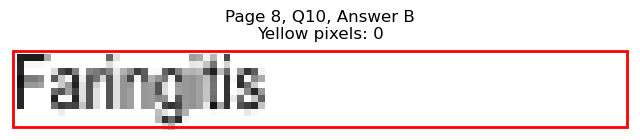

Page 8, Q10 - C: Detected box: x0=327.5, y0=659.1, x1=416.3, y1=670.2
Page 8, Q10, C: Yellow pixels: 140
Page 8, Q10, C: Total non-white pixels: 759
Page 8, Q10, C: Yellow percentage: 18.4%


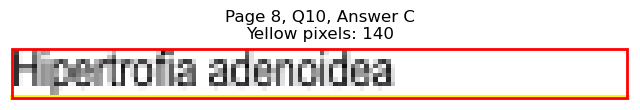

Page 8, Q10 - D: Detected box: x0=327.5, y0=671.7, x1=429.8, y1=682.8
Page 8, Q10, D: Yellow pixels: 1445
Page 8, Q10, D: Total non-white pixels: 1836
Page 8, Q10, D: Yellow percentage: 78.7%


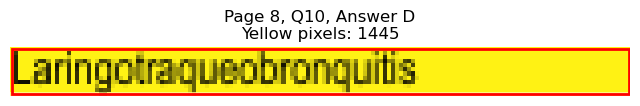


Page 8, Q10 - Selected Answer: D (based on yellow pixel count)




Page 8, Q11 - A: Detected box: x0=56.6, y0=722.2, x1=65.2, y1=733.3
Page 8, Q11, A: Yellow pixels: 608
Page 8, Q11, A: Total non-white pixels: 720
Page 8, Q11, A: Yellow percentage: 84.4%


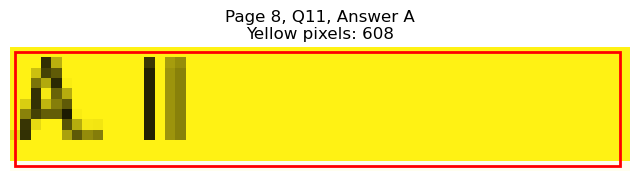

Page 8, Q11 - B: Detected box: x0=68.3, y0=734.8, x1=85.3, y1=745.9
Page 8, Q11, B: Yellow pixels: 0
Page 8, Q11, B: Total non-white pixels: 68
Page 8, Q11, B: Yellow percentage: 0.0%


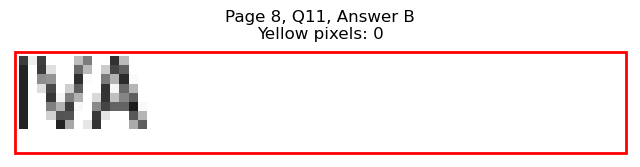

Page 8, Q11 - C: Detected box: x0=327.5, y0=722.2, x1=337.6, y1=733.3
Page 8, Q11, C: Yellow pixels: 0
Page 8, Q11, C: Total non-white pixels: 48
Page 8, Q11, C: Yellow percentage: 0.0%


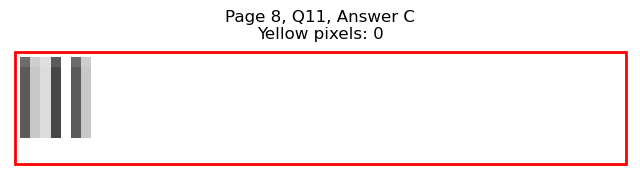

Page 8, Q11 - D: Detected box: x0=315.4, y0=734.8, x1=324.4, y1=745.9
Page 8, Q11, D: Yellow pixels: 0
Page 8, Q11, D: Total non-white pixels: 58
Page 8, Q11, D: Yellow percentage: 0.0%


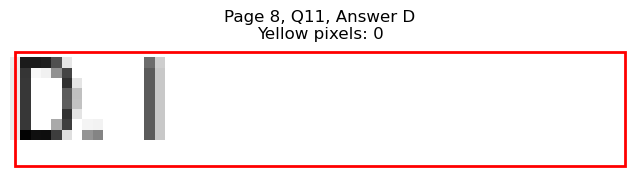


Page 8, Q11 - Selected Answer: A (based on yellow pixel count)





Page 9: Found 11 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=251.8, y1=102.2
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 936
Page 9, Q1, A: Yellow percentage: 0.0%


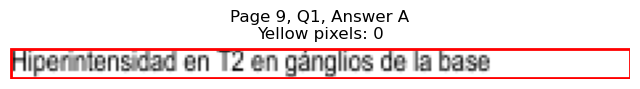

Page 9, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=208.7, y1=114.8
Page 9, Q1, B: Yellow pixels: 191
Page 9, Q1, B: Total non-white pixels: 912
Page 9, Q1, B: Yellow percentage: 20.9%


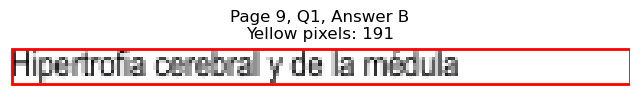

Page 9, Q1 - C: Detected box: x0=68.8, y0=116.4, x1=317.5, y1=127.4
Page 9, Q1, C: Yellow pixels: 2389
Page 9, Q1, C: Total non-white pixels: 3600
Page 9, Q1, C: Yellow percentage: 66.4%


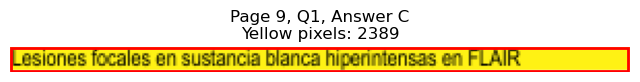

Page 9, Q1 - D: Detected box: x0=68.8, y0=129.0, x1=297.0, y1=140.0
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 1087
Page 9, Q1, D: Yellow percentage: 0.0%


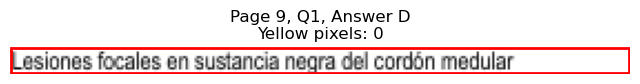


Page 9, Q1 - Selected Answer: C (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=192.1, x1=119.9, y1=203.1
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 272
Page 9, Q2, A: Yellow percentage: 0.0%


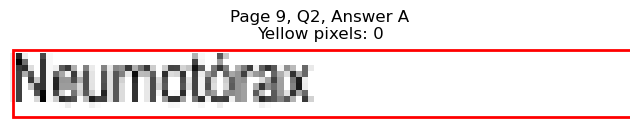

Page 9, Q2 - B: Detected box: x0=68.3, y0=204.7, x1=132.5, y1=215.7
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 333
Page 9, Q2, B: Yellow percentage: 0.0%


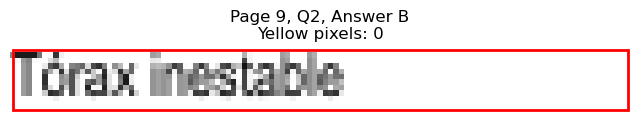

Page 9, Q2 - C: Detected box: x0=327.5, y0=192.1, x1=416.8, y1=203.1
Page 9, Q2, C: Yellow pixels: 1201
Page 9, Q2, C: Total non-white pixels: 1540
Page 9, Q2, C: Yellow percentage: 78.0%


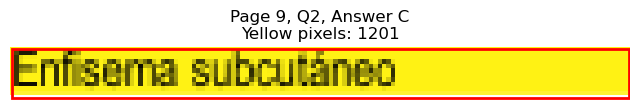

Page 9, Q2 - D: Detected box: x0=327.5, y0=204.7, x1=410.8, y1=215.7
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 419
Page 9, Q2, D: Yellow percentage: 0.0%


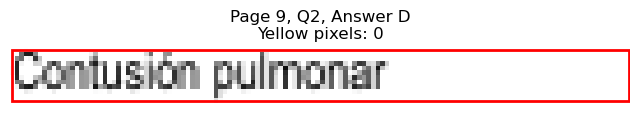


Page 9, Q2 - Selected Answer: C (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=255.2, x1=109.0, y1=266.2
Page 9, Q3, A: Yellow pixels: 91
Page 9, Q3, A: Total non-white pixels: 287
Page 9, Q3, A: Yellow percentage: 31.7%


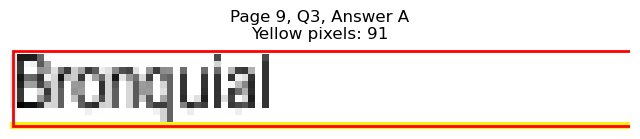

Page 9, Q3 - B: Detected box: x0=68.3, y0=267.8, x1=98.9, y1=278.8
Page 9, Q3, B: Yellow pixels: 860
Page 9, Q3, B: Total non-white pixels: 972
Page 9, Q3, B: Yellow percentage: 88.5%


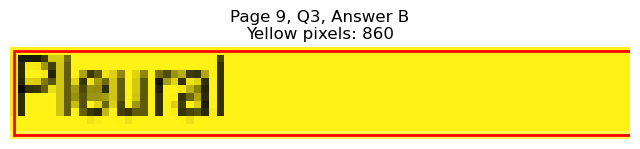

Page 9, Q3 - C: Detected box: x0=327.5, y0=255.2, x1=362.6, y1=266.2
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 173
Page 9, Q3, C: Yellow percentage: 0.0%


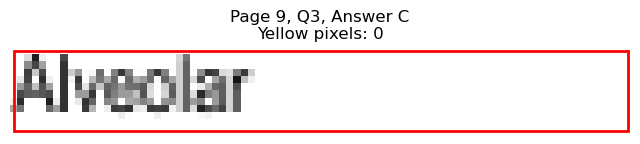

Page 9, Q3 - D: Detected box: x0=327.5, y0=267.8, x1=368.6, y1=278.8
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 186
Page 9, Q3, D: Yellow percentage: 0.0%


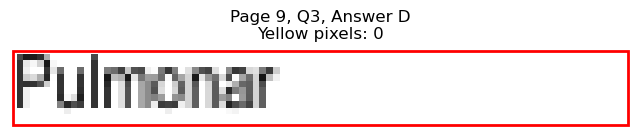


Page 9, Q3 - Selected Answer: B (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=318.3, x1=118.4, y1=329.4
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 243
Page 9, Q4, A: Yellow percentage: 0.0%


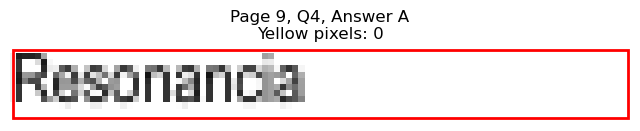

Page 9, Q4 - B: Detected box: x0=68.3, y0=330.9, x1=160.1, y1=342.0
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 508
Page 9, Q4, B: Yellow percentage: 0.0%


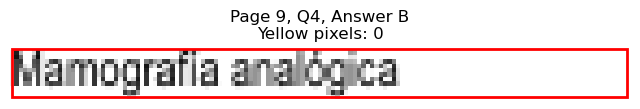

Page 9, Q4 - C: Detected box: x0=327.5, y0=318.3, x1=434.8, y1=329.4
Page 9, Q4, C: Yellow pixels: 1318
Page 9, Q4, C: Total non-white pixels: 1896
Page 9, Q4, C: Yellow percentage: 69.5%


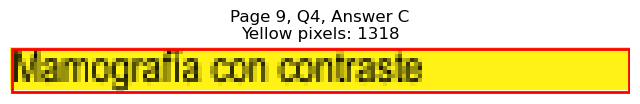

Page 9, Q4 - D: Detected box: x0=327.5, y0=330.9, x1=368.6, y1=342.0
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 221
Page 9, Q4, D: Yellow percentage: 0.0%


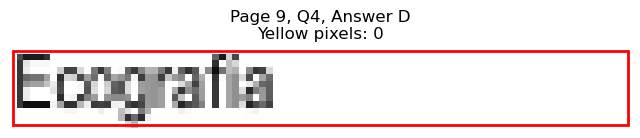


Page 9, Q4 - Selected Answer: C (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=381.4, x1=112.4, y1=392.5
Page 9, Q5, A: Yellow pixels: 95
Page 9, Q5, A: Total non-white pixels: 322
Page 9, Q5, A: Yellow percentage: 29.5%


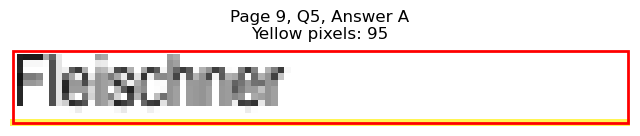

Page 9, Q5 - B: Detected box: x0=68.3, y0=394.0, x1=150.0, y1=405.1
Page 9, Q5, B: Yellow pixels: 1145
Page 9, Q5, B: Total non-white pixels: 1454
Page 9, Q5, B: Yellow percentage: 78.7%


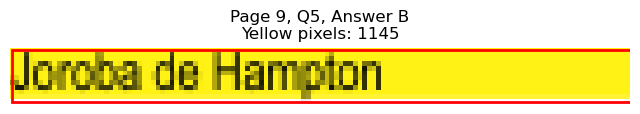

Page 9, Q5 - C: Detected box: x0=327.5, y0=381.4, x1=378.6, y1=392.5
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 271
Page 9, Q5, C: Yellow percentage: 0.0%


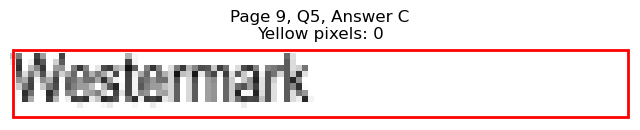

Page 9, Q5 - D: Detected box: x0=327.5, y0=394.0, x1=380.2, y1=405.1
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 255
Page 9, Q5, D: Yellow percentage: 0.0%


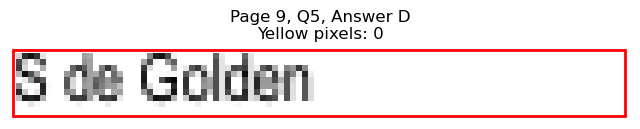


Page 9, Q5 - Selected Answer: B (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=444.6, x1=169.1, y1=455.6
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 492
Page 9, Q6, A: Yellow percentage: 0.0%


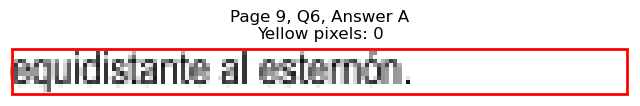

Page 9, Q6 - B: Detected box: x0=68.3, y0=457.2, x1=248.8, y1=468.2
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 857
Page 9, Q6, B: Yellow percentage: 0.0%


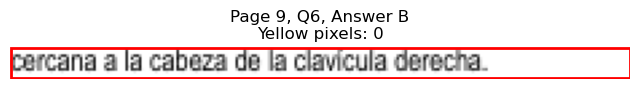

Page 9, Q6 - C: Detected box: x0=327.5, y0=444.6, x1=512.0, y1=455.6
Page 9, Q6, C: Yellow pixels: 1639
Page 9, Q6, C: Total non-white pixels: 2556
Page 9, Q6, C: Yellow percentage: 64.1%


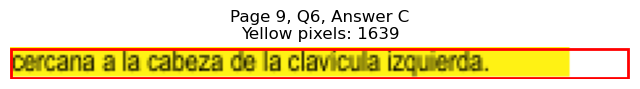

Page 9, Q6 - D: Detected box: x0=327.5, y0=457.2, x1=406.2, y1=468.2
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 398
Page 9, Q6, D: Yellow percentage: 0.0%


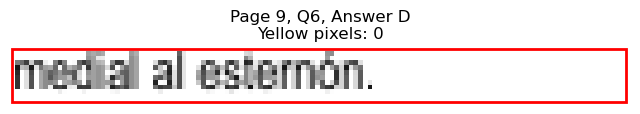


Page 9, Q6 - Selected Answer: C (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=495.1, x1=96.4, y1=506.1
Page 9, Q7, A: Yellow pixels: 79
Page 9, Q7, A: Total non-white pixels: 309
Page 9, Q7, A: Yellow percentage: 25.6%


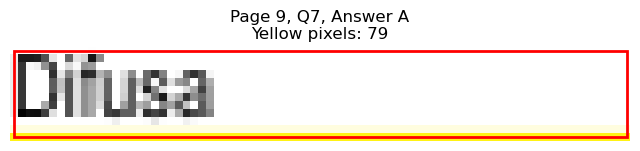

Page 9, Q7 - B: Detected box: x0=68.3, y0=507.7, x1=122.5, y1=518.7
Page 9, Q7, B: Yellow pixels: 1026
Page 9, Q7, B: Total non-white pixels: 1260
Page 9, Q7, B: Yellow percentage: 81.4%


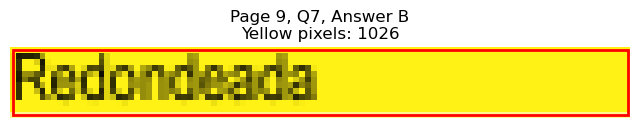

Page 9, Q7 - C: Detected box: x0=327.5, y0=495.1, x1=368.2, y1=506.1
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 209
Page 9, Q7, C: Yellow percentage: 0.0%


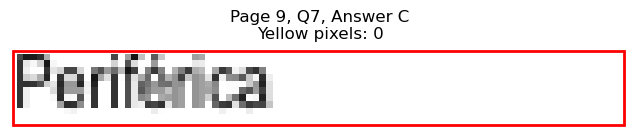

Page 9, Q7 - D: Detected box: x0=327.5, y0=507.7, x1=360.1, y1=518.7
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 140
Page 9, Q7, D: Yellow percentage: 0.0%


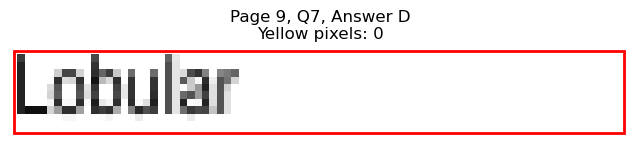


Page 9, Q7 - Selected Answer: B (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=558.2, x1=139.6, y1=569.2
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 350
Page 9, Q8, A: Yellow percentage: 0.0%


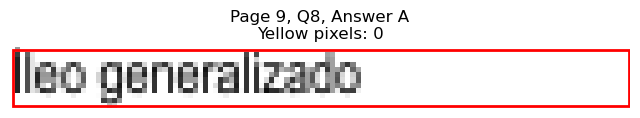

Page 9, Q8 - B: Detected box: x0=68.3, y0=570.8, x1=156.0, y1=581.8
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 446
Page 9, Q8, B: Yellow percentage: 0.0%


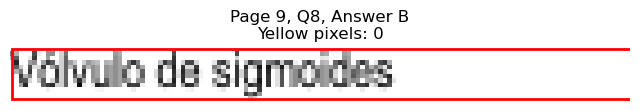

Page 9, Q8 - C: Detected box: x0=327.5, y0=558.2, x1=387.1, y1=569.2
Page 9, Q8, C: Yellow pixels: 111
Page 9, Q8, C: Total non-white pixels: 426
Page 9, Q8, C: Yellow percentage: 26.1%


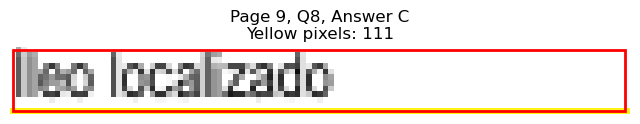

Page 9, Q8 - D: Detected box: x0=327.5, y0=570.8, x1=461.4, y1=581.8
Page 9, Q8, D: Yellow pixels: 1715
Page 9, Q8, D: Total non-white pixels: 2220
Page 9, Q8, D: Yellow percentage: 77.3%


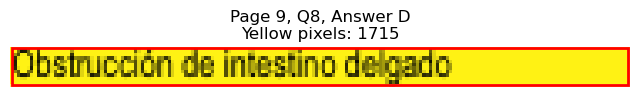


Page 9, Q8 - Selected Answer: D (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=633.9, x1=168.6, y1=645.0
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 640
Page 9, Q9, A: Yellow percentage: 0.0%


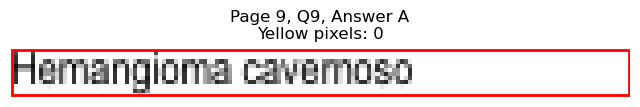

Page 9, Q9 - B: Detected box: x0=68.3, y0=646.5, x1=171.1, y1=657.6
Page 9, Q9, B: Yellow pixels: 1328
Page 9, Q9, B: Total non-white pixels: 1848
Page 9, Q9, B: Yellow percentage: 71.9%


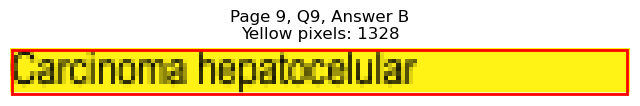

Page 9, Q9 - C: Detected box: x0=327.5, y0=633.9, x1=429.2, y1=645.0
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 548
Page 9, Q9, C: Yellow percentage: 0.0%


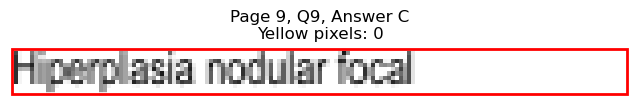

Page 9, Q9 - D: Detected box: x0=327.5, y0=646.5, x1=426.2, y1=657.6
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 527
Page 9, Q9, D: Yellow percentage: 0.0%


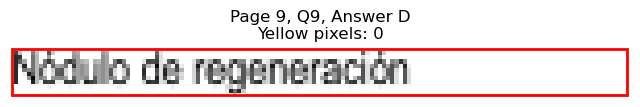


Page 9, Q9 - Selected Answer: B (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=68.3, y0=684.3, x1=189.6, y1=695.4
Page 9, Q10, A: Yellow pixels: 1435
Page 9, Q10, A: Total non-white pixels: 2064
Page 9, Q10, A: Yellow percentage: 69.5%


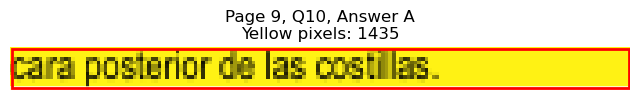

Page 9, Q10 - B: Detected box: x0=68.3, y0=697.0, x1=185.6, y1=708.1
Page 9, Q10, B: Yellow pixels: 0
Page 9, Q10, B: Total non-white pixels: 587
Page 9, Q10, B: Yellow percentage: 0.0%


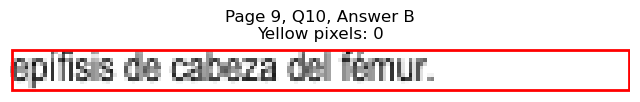

Page 9, Q10 - C: Detected box: x0=327.5, y0=684.3, x1=399.7, y1=695.4
Page 9, Q10, C: Yellow pixels: 0
Page 9, Q10, C: Total non-white pixels: 334
Page 9, Q10, C: Yellow percentage: 0.0%


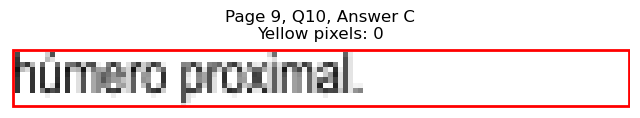

Page 9, Q10 - D: Detected box: x0=327.5, y0=697.0, x1=394.7, y1=708.1
Page 9, Q10, D: Yellow pixels: 0
Page 9, Q10, D: Total non-white pixels: 355
Page 9, Q10, D: Yellow percentage: 0.0%


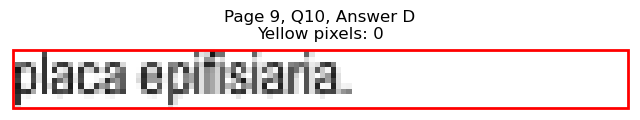


Page 9, Q10 - Selected Answer: A (based on yellow pixel count)




Page 9, Q11 - A: Detected box: x0=68.3, y0=734.8, x1=107.9, y1=745.9
Page 9, Q11, A: Yellow pixels: 0
Page 9, Q11, A: Total non-white pixels: 164
Page 9, Q11, A: Yellow percentage: 0.0%


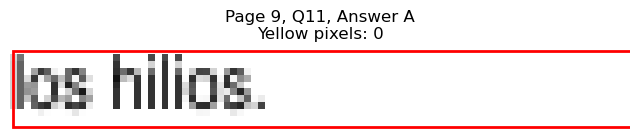

Page 9, Q11 - B: Detected box: x0=68.3, y0=747.4, x1=113.4, y1=758.5
Page 9, Q11, B: Yellow pixels: 0
Page 9, Q11, B: Total non-white pixels: 213
Page 9, Q11, B: Yellow percentage: 0.0%


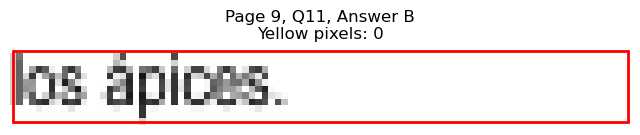

Page 9, Q11 - C: Detected box: x0=327.5, y0=734.8, x1=370.7, y1=745.9
Page 9, Q11, C: Yellow pixels: 976
Page 9, Q11, C: Total non-white pixels: 1128
Page 9, Q11, C: Yellow percentage: 86.5%


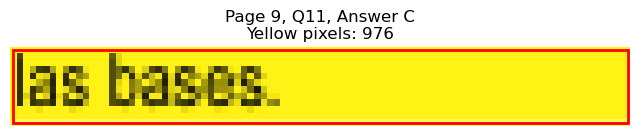

Page 9, Q11 - D: Detected box: x0=327.5, y0=747.4, x1=411.2, y1=758.5
Page 9, Q11, D: Yellow pixels: 0
Page 9, Q11, D: Total non-white pixels: 429
Page 9, Q11, D: Yellow percentage: 0.0%


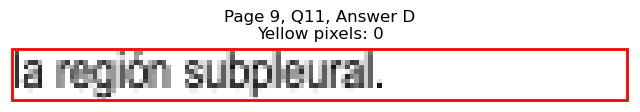


Page 9, Q11 - Selected Answer: C (based on yellow pixel count)





Page 10: Found 1 questions
Page 10, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=91.3, y1=102.2
Page 10, Q1, A: Yellow pixels: 717
Page 10, Q1, A: Total non-white pixels: 814
Page 10, Q1, A: Yellow percentage: 88.1%


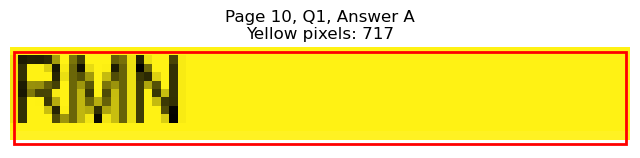

Page 10, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=82.8, y1=114.8
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 56
Page 10, Q1, B: Yellow percentage: 0.0%


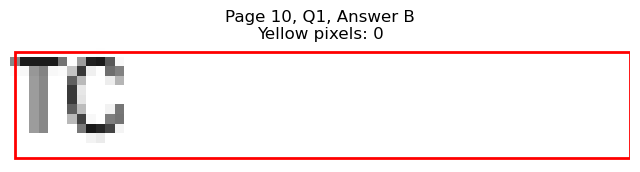

Page 10, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=368.6, y1=102.2
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 221
Page 10, Q1, C: Yellow percentage: 0.0%


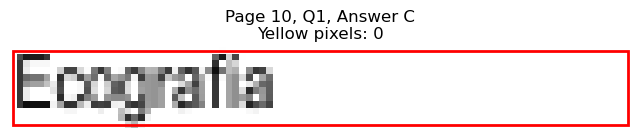

Page 10, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=402.8, y1=114.8
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 435
Page 10, Q1, D: Yellow percentage: 0.0%


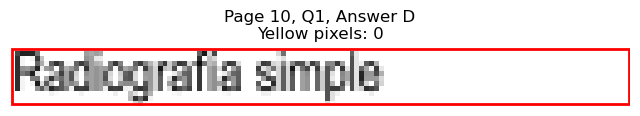


Page 10, Q1 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   ¿Cuál es la complicación más frecuente de la f...
1   Niño de 5 años con dolor en pierna post trauma...
2   En el estadiaje de cáncer de recto. RMN: lesió...
3   ¿Cuál es el signo ecográfico más característic...
4   Varón de 60 años, diagnosticado de VIH, con ad...
..                                                ...
95  Mujer de 40 años con vómitos, dolor y distensi...
96  Varón de 79 años, con dolor abdominal y masa p...
97  Es indicativo de maltrato infantil, la fractur...
98  En una radiografía de tórax normal obtenida en...
99  ¿Cuál es la técnica de elección para la evalua...

[100 rows x 1 columns]

In [8]:
answers_df

option_A                                option_B  \
0                 Necrosis avascular                                Luxación   
1          Metástasis osteoblásticas                           Osteomielitis   
2                                 T3                                      T4   
3                       Apendicolito  Grasa perientérica levemente inflamada   
4                            Linfoma                         Bocio sumergido   
..                               ...                                     ...   
95                 Íleo generalizado                    Vólvulo de sigmoides   
96              Hemangioma cavernoso                 Carcinoma hepatocelular   
97  cara posterior de las costillas.           epífisis de cabeza del fémur.   
98                       los hilios.                             los ápices.   
99                               RMN                                      TC   

                     option_C                          option_D  
0   Ausencia de consolidación              Consolidación tardía  
1          Fractura conminuta                      Osteoporosis  
2                          T1                                T2  
3     Apéndice no compresible        Líquido pericecal loculado  
4                    Teratoma                            Timoma  
..                        ...                               ...  
95            Íleo localizado  Obstrucción de intestino delgado  
96  Hiperplasia nodular focal            Nódulo de regeneración  
97           húmero proximal.                placa epifisiaria.  
98                 las bases.             la región subpleural.  
99                  Ecografía                Radiografía simple  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               A
1               B
2               A
3               D
4               A
..            ...
95              D
96              B
97              A
98              C
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   ¿Cuál es la complicación más frecuente de la f...   
1   Niño de 5 años con dolor en pierna post trauma...   
2   En el estadiaje de cáncer de recto. RMN: lesió...   
3   ¿Cuál es el signo ecográfico más característic...   
4   Varón de 60 años, diagnosticado de VIH, con ad...   
..                                                ...   
95  Mujer de 40 años con vómitos, dolor y distensi...   
96  Varón de 79 años, con dolor abdominal y masa p...   
97  Es indicativo de maltrato infantil, la fractur...   
98  En una radiografía de tórax normal obtenida en...   
99  ¿Cuál es la técnica de elección para la evalua...   

                            option_A                                option_B  \
0                 Necrosis avascular                                Luxación   
1          Metástasis osteoblásticas                           Osteomielitis   
2                                 T3                                      T4   
3                       Apendicolito  Grasa perientérica levemente inflamada   
4                            Linfoma                         Bocio sumergido   
..                               ...                                     ...   
95                 Íleo generalizado                    Vólvulo de sigmoides   
96              Hemangioma cavernoso                 Carcinoma hepatocelular   
97  cara posterior de las costillas.           epífisis de cabeza del fémur.   
98                       los hilios.                             los ápices.   
99                               RMN                                      TC   

                     option_C                          option_D correct_answer  
0   Ausencia de consolidación              Consolidación tardía              A  
1          Fractura conminuta                      Osteoporosis              B  
2                          T1                                T2              A  
3     Apéndice no compresible        Líquido pericecal loculado              D  
4                    Teratoma                            Timoma              A  
..                        ...                               ...            ...  
95            Íleo localizado  Obstrucción de intestino delgado              D  
96  Hiperplasia nodular focal            Nódulo de regeneración              B  
97           húmero proximal.                placa epifisiaria.              A  
98                 las bases.             la región subpleural.              C  
99                  Ecografía                Radiografía simple              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Documents/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2025/RADIOLOGIA.csv
